In [ ]:
òimport numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=65f710ca58f3cf08a3bde6fa9d56a74be39cf6517364ea457c16b077d73f21bc
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The code is divided in two blocks:
*   Analysis on standard dataset
*   Analysis on noisy dataset

Since the models are the same for each block, these are defined early in the notebook, as the early stopping criterion.
Each block have the same layout:

*   Model trainig
*   Training and validation curve
*   Model evalutaion on the test
*   Metrics calculation with confusion matrix

NB: all the notebook could be runned sequentially all at once, but I suggest to run it before with standard dataset, then reinitialize the session and run the analysis for noisy dataset, in order to not encounter any ram issue.

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def custom_res_block(X, kernel_size, n_filter):

    X_1=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out



def CNN_v3(input_shape, output_shape):
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(4,4), padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((3,3), strides=(2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X=custom_res_block(X, (2,3), 16)

    X=tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=128)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model



def CNN_v2(input_shape, output_shape):
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(5,8), strides=(2,2),padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=custom_res_block(X, (5,5), 16)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(24, (2,3))(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(32, (2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Conv2D(32, (1,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=256)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Dense(units=64)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


def residual_block(X, filters, kernel_size, index):
    d=int(2**(np.trunc(index/3)))

    X_1=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out


def resnet8(input_shape, output_shape):
    X_input = layers.Input(shape=input_shape)

    X=tf.keras.layers.Conv2D(19, kernel_size=(3,3),padding='same')(X_input)
    X=tf.keras.layers.AveragePooling2D((4,3))(X)

    for i in range(3):
      X=residual_block(X, filters=19, kernel_size=(3,3), index=i)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)
    X=tf.keras.layers.Flatten()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


In [ ]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Train Models with MFCC features**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='mfcc')
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc')
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='mfcc', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 9, 33, 19)            0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 9, 33, 19)            3268      ['average_pooling2d[0][0]'

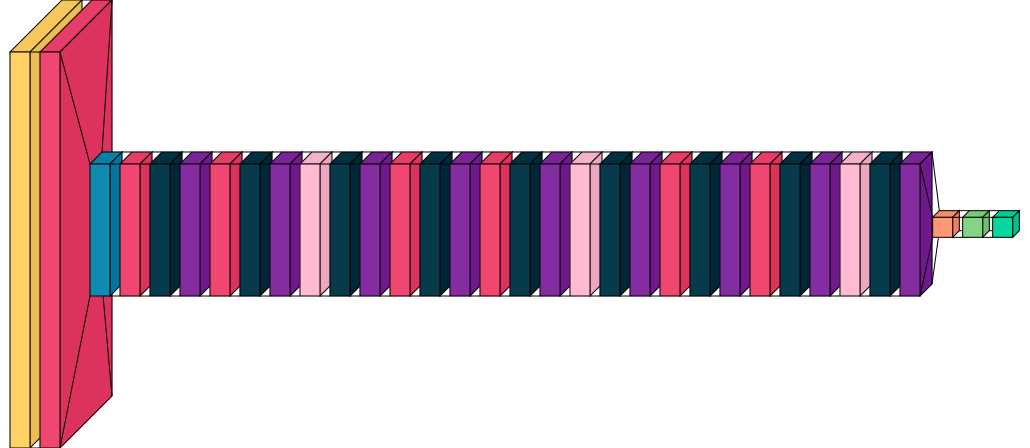

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

resnet8_m=resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [ ]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8_m=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 467s 359ms/step - loss: 2.6710 - sparse_categorical_accuracy: 0.3016 - val_loss: 1.9967 - val_sparse_categorical_accuracy: 0.4459
Epoch 2/25
497/497 [==============================] - 78s 156ms/step - loss: 1.5685 - sparse_categorical_accuracy: 0.5735 - val_loss: 1.3627 - val_sparse_categorical_accuracy: 0.6186
Epoch 3/25
497/497 [==============================] - 82s 164ms/step - loss: 1.1829 - sparse_categorical_accuracy: 0.6704 - val_loss: 1.1903 - val_sparse_categorical_accuracy: 0.6605
Epoch 4/25
497/497 [==============================] - 82s 164ms/step - loss: 0.9957 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.9593 - val_sparse_categorical_accuracy: 0.7283
Epoch 5/25
497/497 [==============================] - 76s 153ms/step - loss: 0.8809 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9380 - val_sparse_categorical_accuracy: 0.7294
Epoch 6/25
497/497 [==============================] - 77s 155ms/step - loss: 0.8057 

In [ ]:
#resnet8_m.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('resnet8_m_mfcc'))

resnet8_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('resnet8_m_mfcc'))

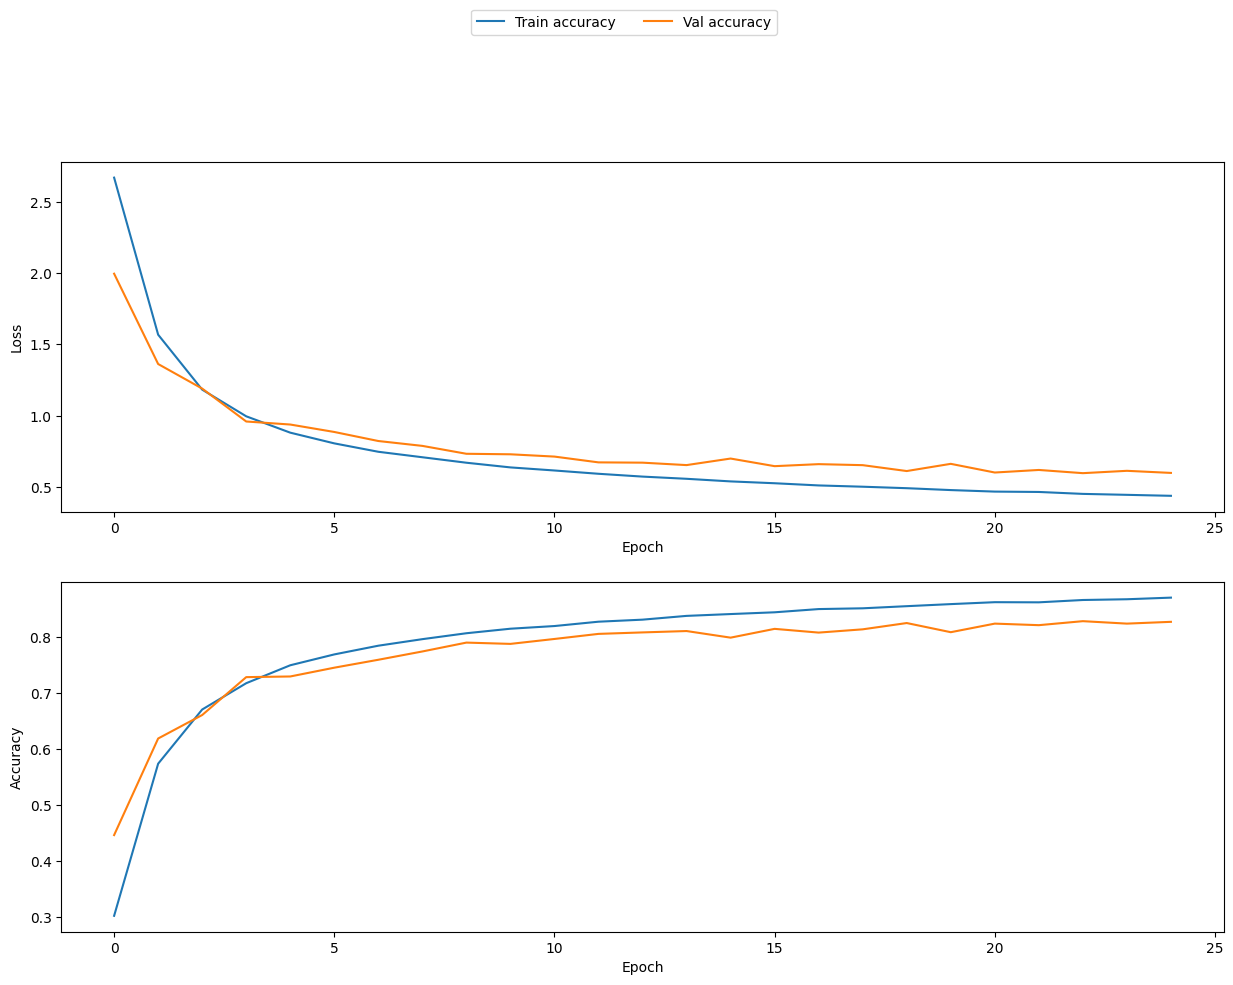

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_resnet8_m.history['loss'], label='Train loss')
axis[0].plot(history_resnet8_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 6s 33ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.831105,0.81626,0.832028,0.831105,0.818781,0.837052,0.831105,0.825997,0.831105,0.831105,0.81626,resnet8_m


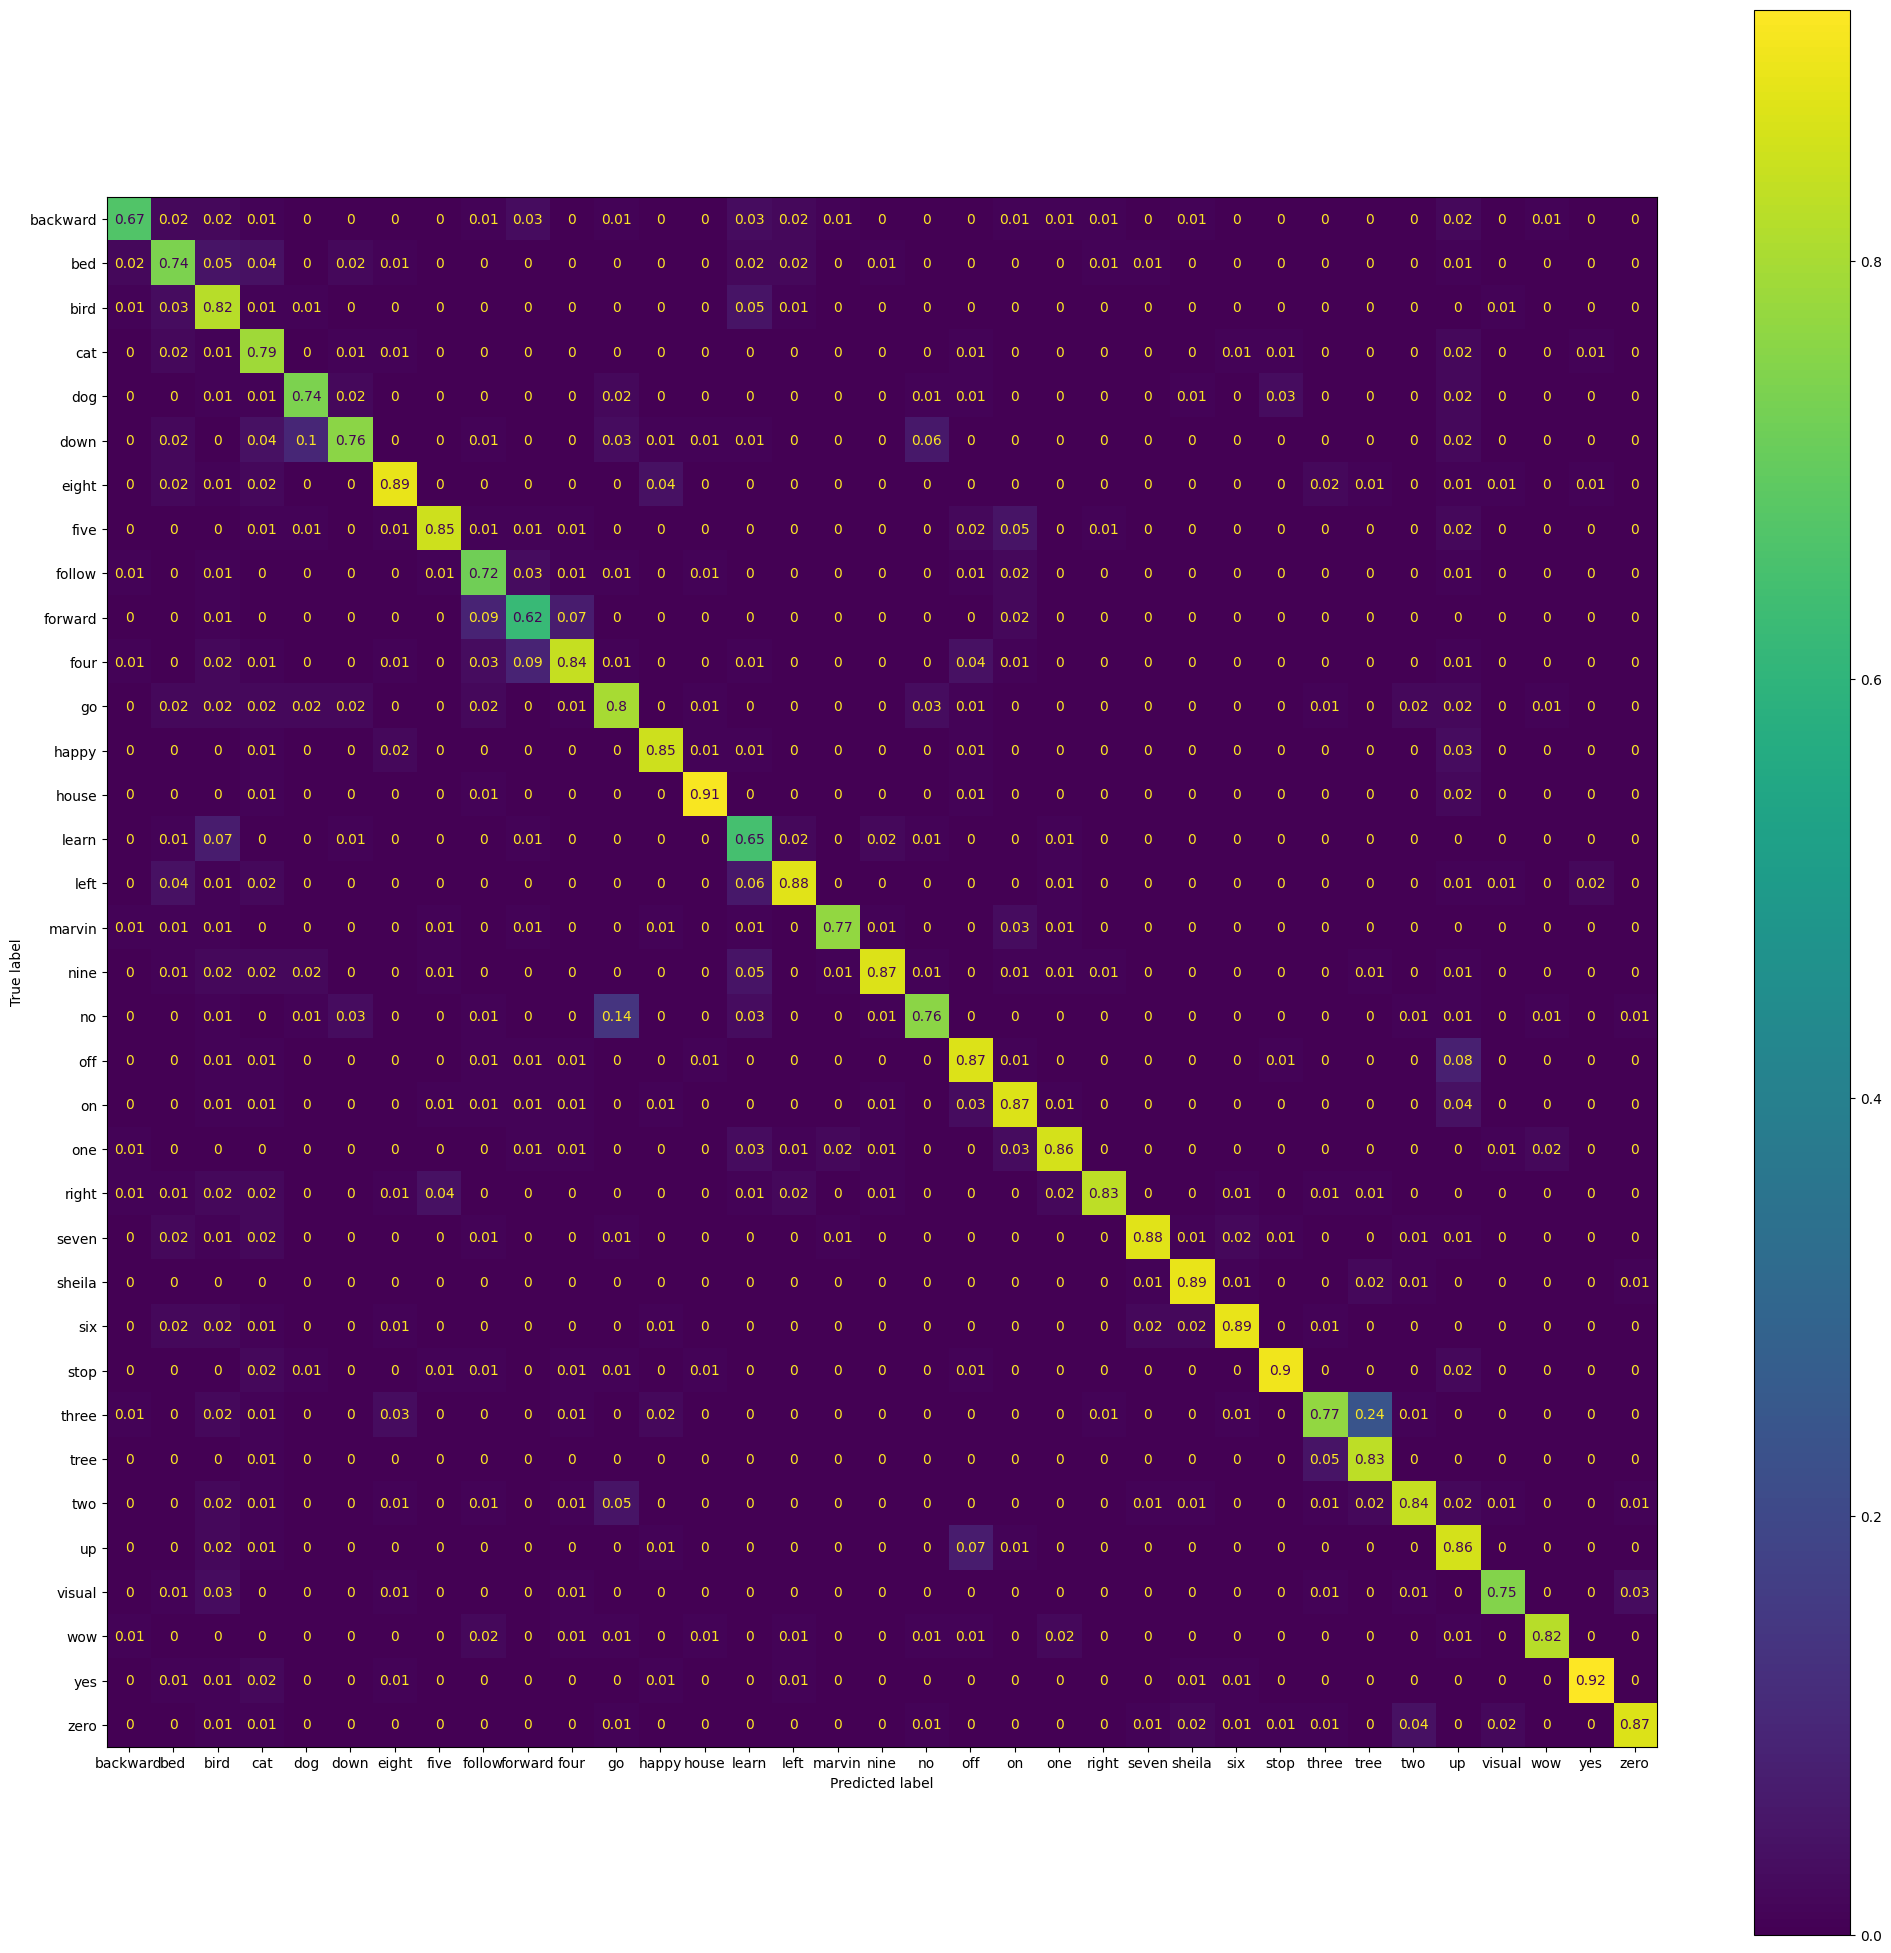

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 20, 50, 8)            328       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 20, 50, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 20, 50, 8)            32        ['activation[0][0]']          
 Normalization)                                                                               

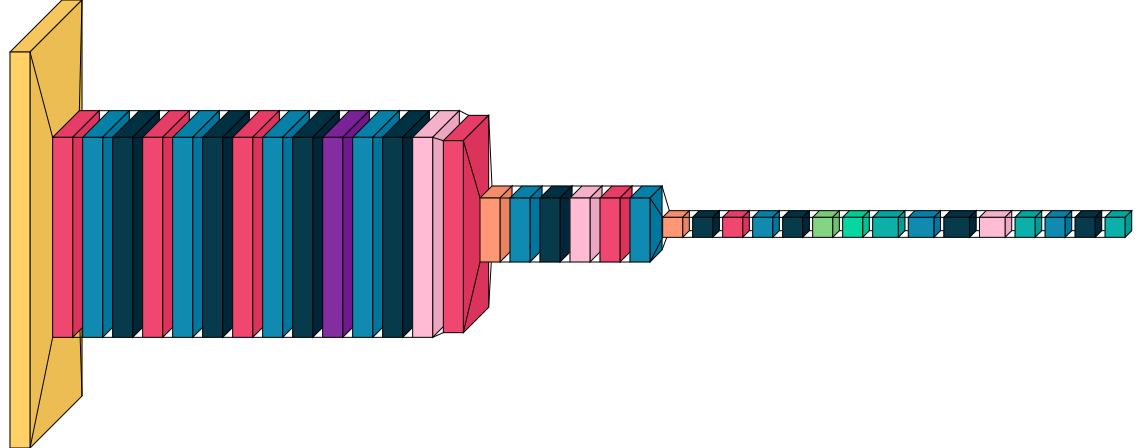

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CNN_v2_m = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2_m.summary())
visualkeras.layered_view(CNN_v2_m)

In [ ]:
CNN_v2_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 94s 187ms/step - loss: 2.3368 - sparse_categorical_accuracy: 0.3402 - val_loss: 1.4845 - val_sparse_categorical_accuracy: 0.5676
Epoch 2/25
497/497 [==============================] - 88s 177ms/step - loss: 1.2140 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.9382 - val_sparse_categorical_accuracy: 0.7155
Epoch 3/25
497/497 [==============================] - 93s 187ms/step - loss: 0.9462 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.8106 - val_sparse_categorical_accuracy: 0.7547
Epoch 4/25
497/497 [==============================] - 93s 186ms/step - loss: 0.8068 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.6840 - val_sparse_categorical_accuracy: 0.7935
Epoch 5/25
497/497 [==============================] - 93s 187ms/step - loss: 0.7289 - sparse_categorical_accuracy: 0.7802 - val_loss: 0.6322 - val_sparse_categorical_accuracy: 0.8098
Epoch 6/25
497/497 [==============================] - 88s 177ms/step - loss: 0.6717 -

In [ ]:
#CNN_v2_m.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CNN_v2_mfcc'))
CNN_v2_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CNN_v2_mfcc'))

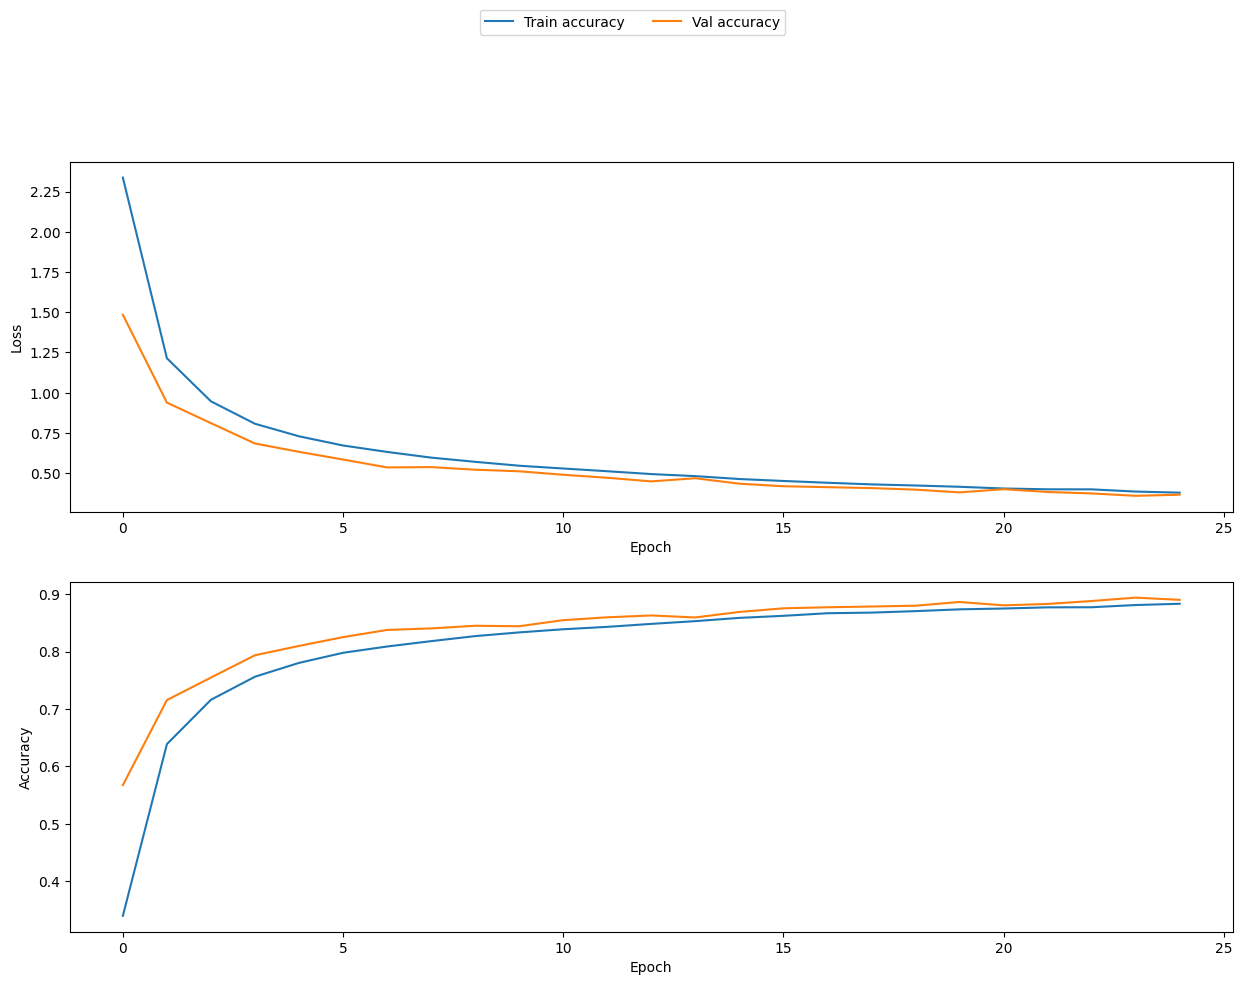

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=CNN_v2_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 4s 25ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.831105,0.816260,0.832028,0.831105,0.818781,0.837052,0.831105,0.825997,0.831105,0.831105,0.816260,resnet8_m
1,0.886805,0.881302,0.887548,0.886805,0.879175,0.891072,0.886805,0.880042,0.886805,0.886805,0.881302,CNN_v2_m


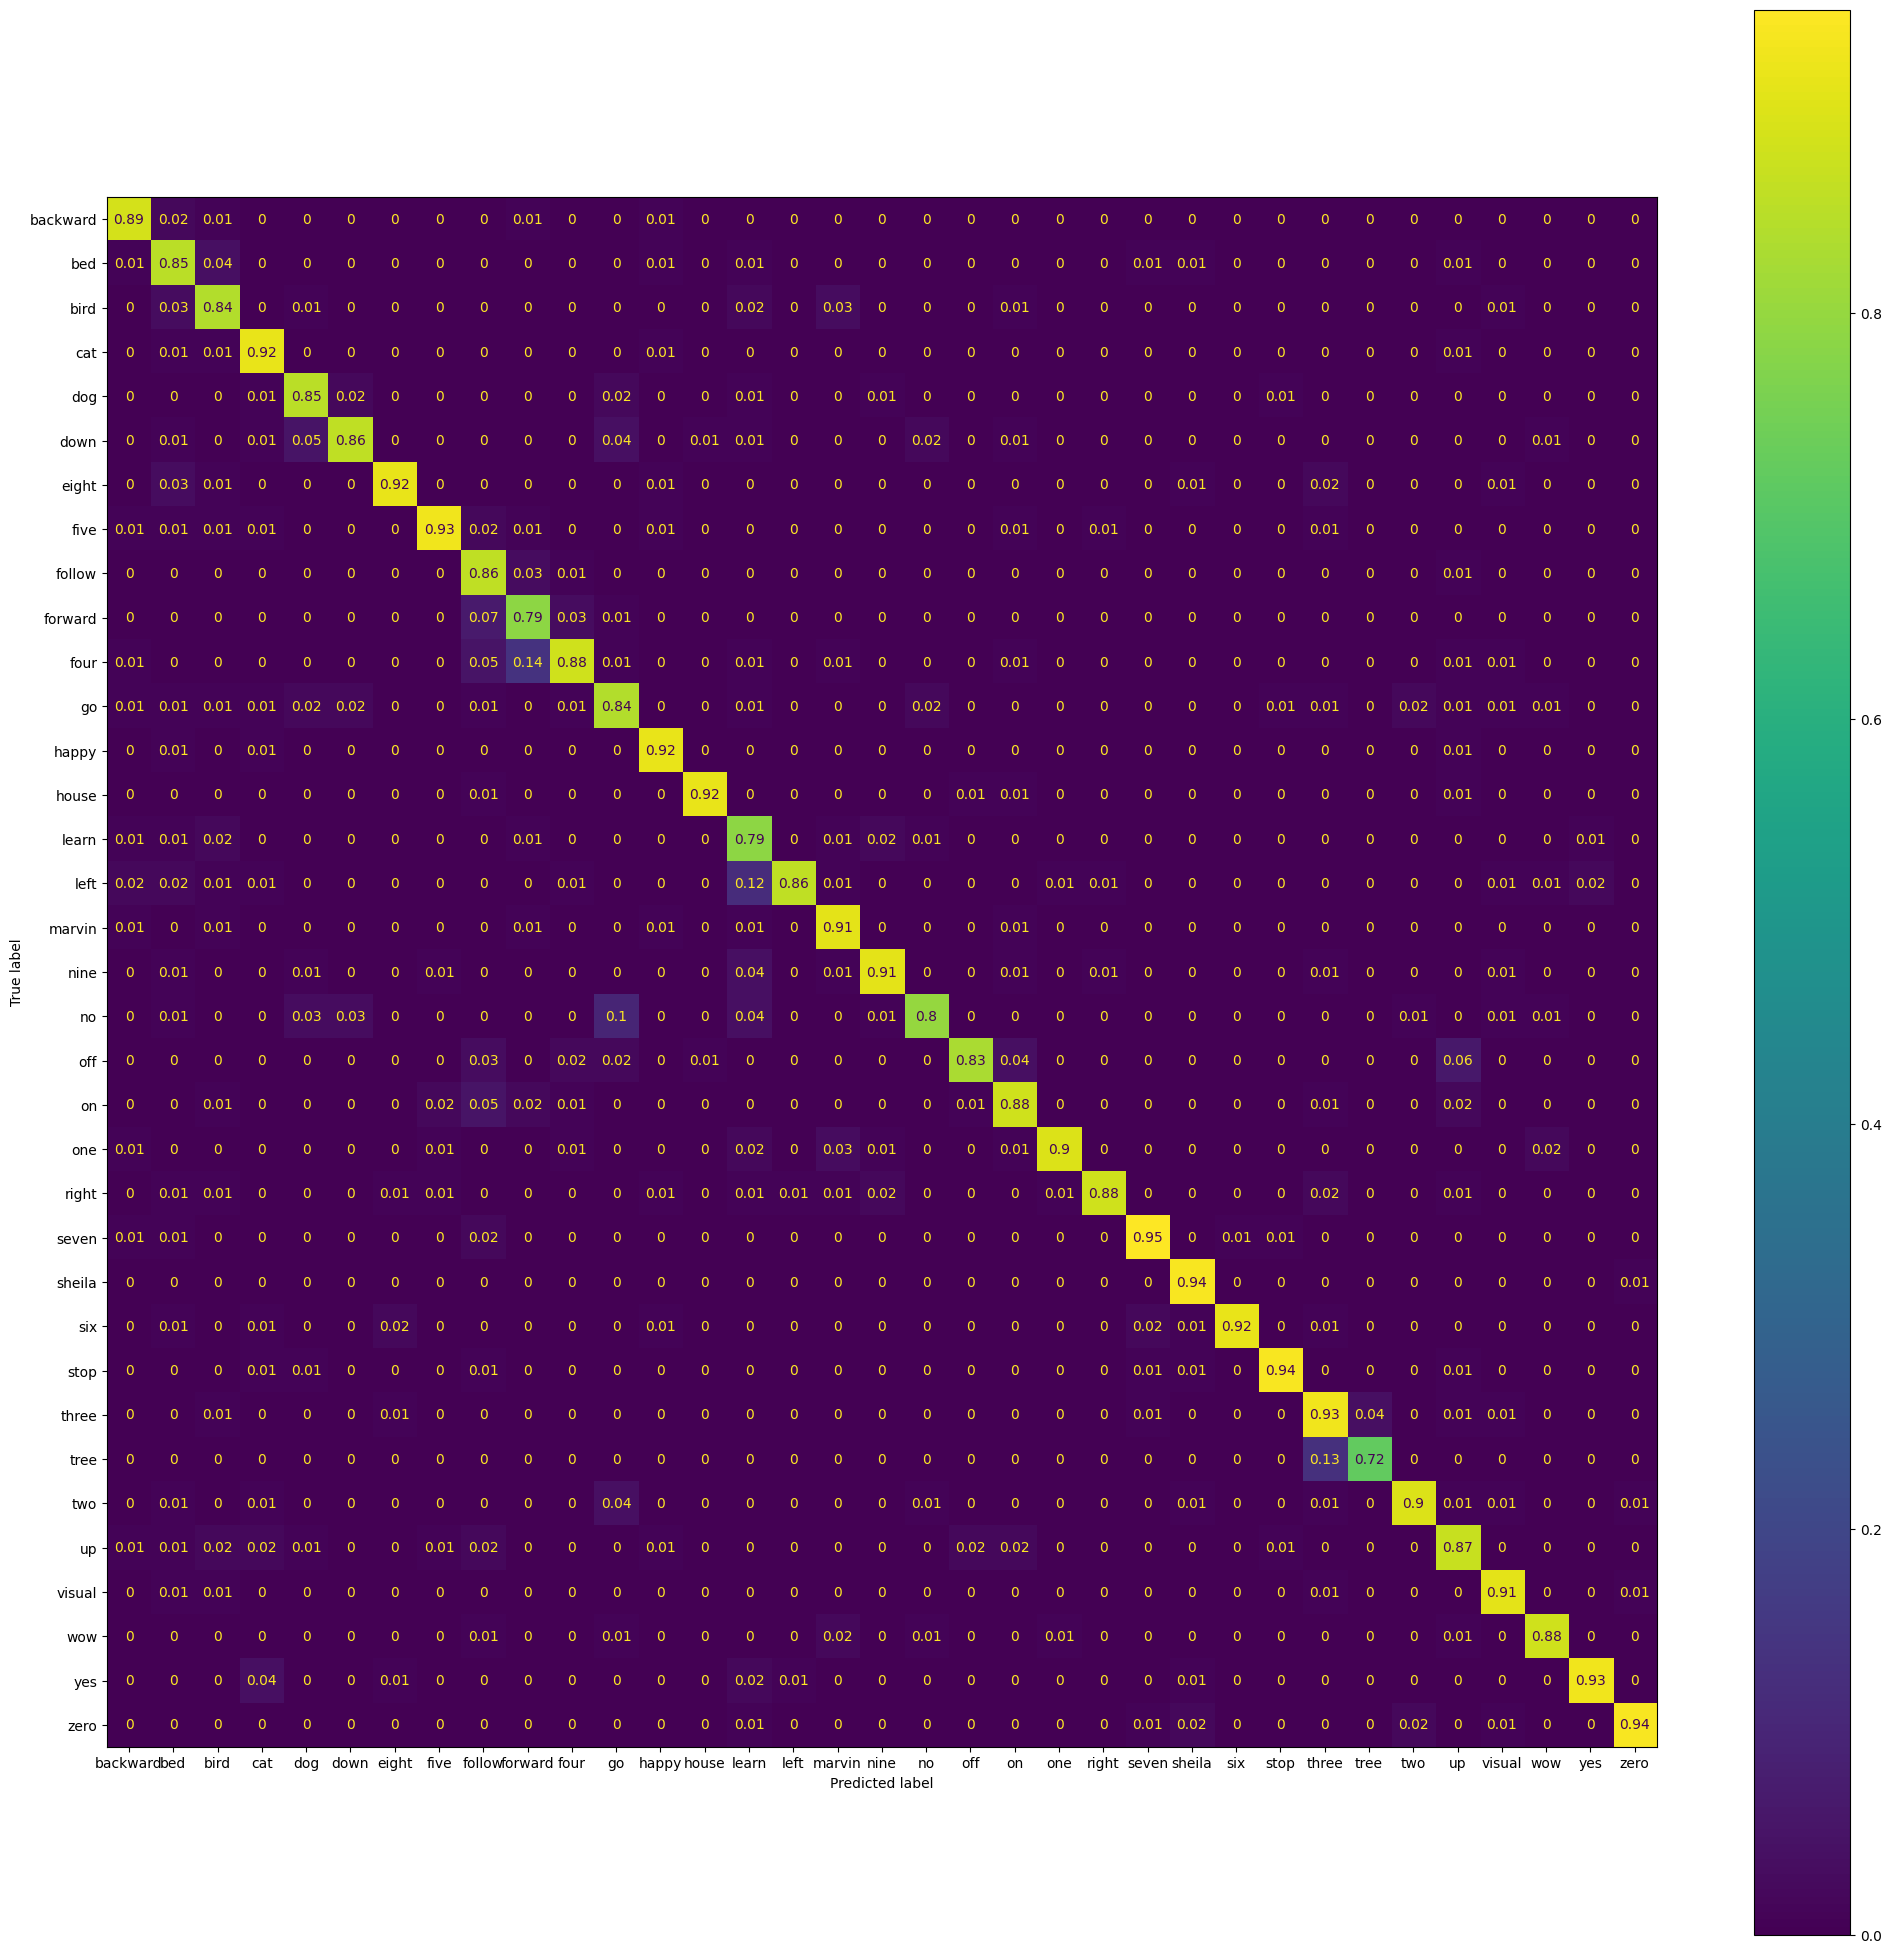

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 39, 99, 8)            136       ['input_2[0][0]']             
                                                                                                  
 activation_6 (Activation)   (None, 39, 99, 8)            0         ['conv2d_4[0][0]']            
                                                                                                  
 average_pooling2d_1 (Avera  (None, 19, 33, 8)            0         ['activation_6[0][0]']        
 gePooling2D)                                                                               

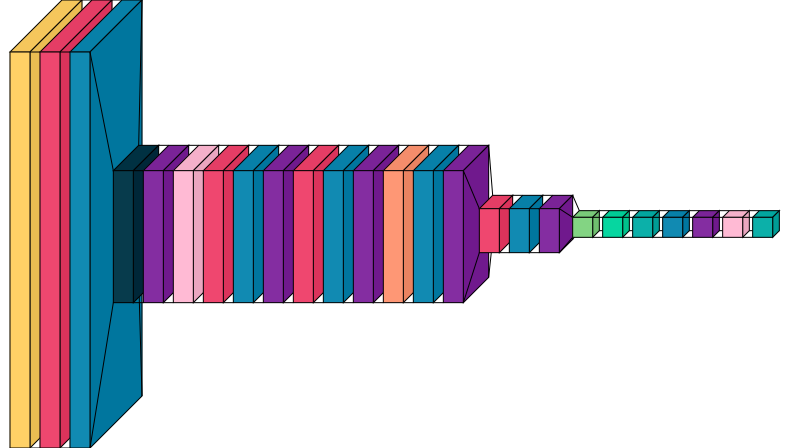

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 84s 163ms/step - loss: 2.4118 - sparse_categorical_accuracy: 0.3276 - val_loss: 1.8066 - val_sparse_categorical_accuracy: 0.5040
Epoch 2/25
497/497 [==============================] - 72s 144ms/step - loss: 1.3758 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.1185 - val_sparse_categorical_accuracy: 0.6739
Epoch 3/25
497/497 [==============================] - 69s 138ms/step - loss: 1.0883 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.9302 - val_sparse_categorical_accuracy: 0.7305
Epoch 4/25
497/497 [==============================] - 65s 130ms/step - loss: 0.9589 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.8260 - val_sparse_categorical_accuracy: 0.7564
Epoch 5/25
497/497 [==============================] - 64s 130ms/step - loss: 0.8805 - sparse_categorical_accuracy: 0.7405 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.7652
Epoch 6/25
497/497 [==============================] - 63s 127ms/step - loss: 0.8278 -

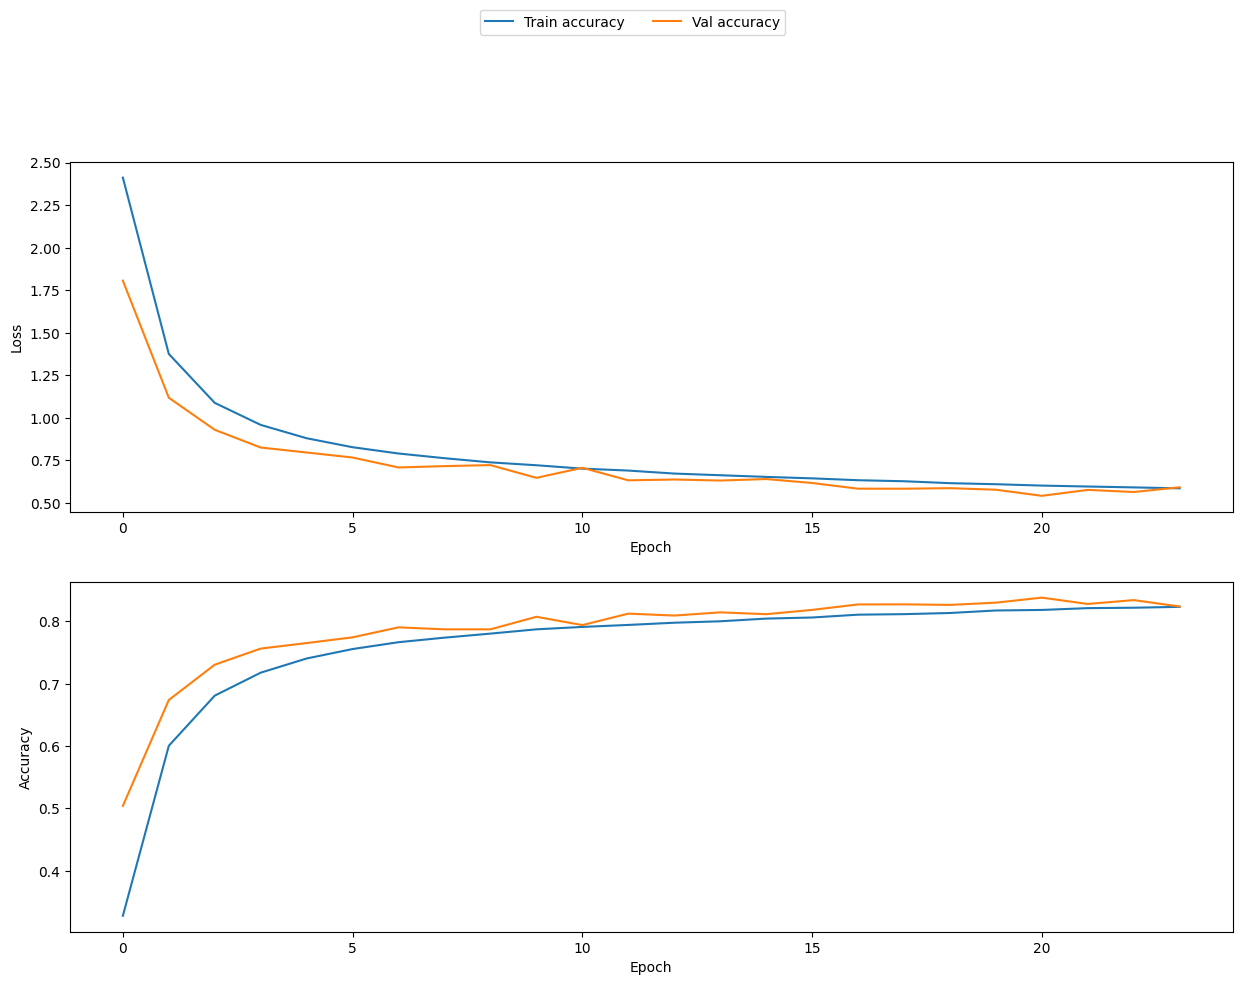

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v3.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
#CNN_v3_m.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CNN_v3_mfcc'))
CNN_v3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('CNN_v3_mfcc'))

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 3s 19ms/step


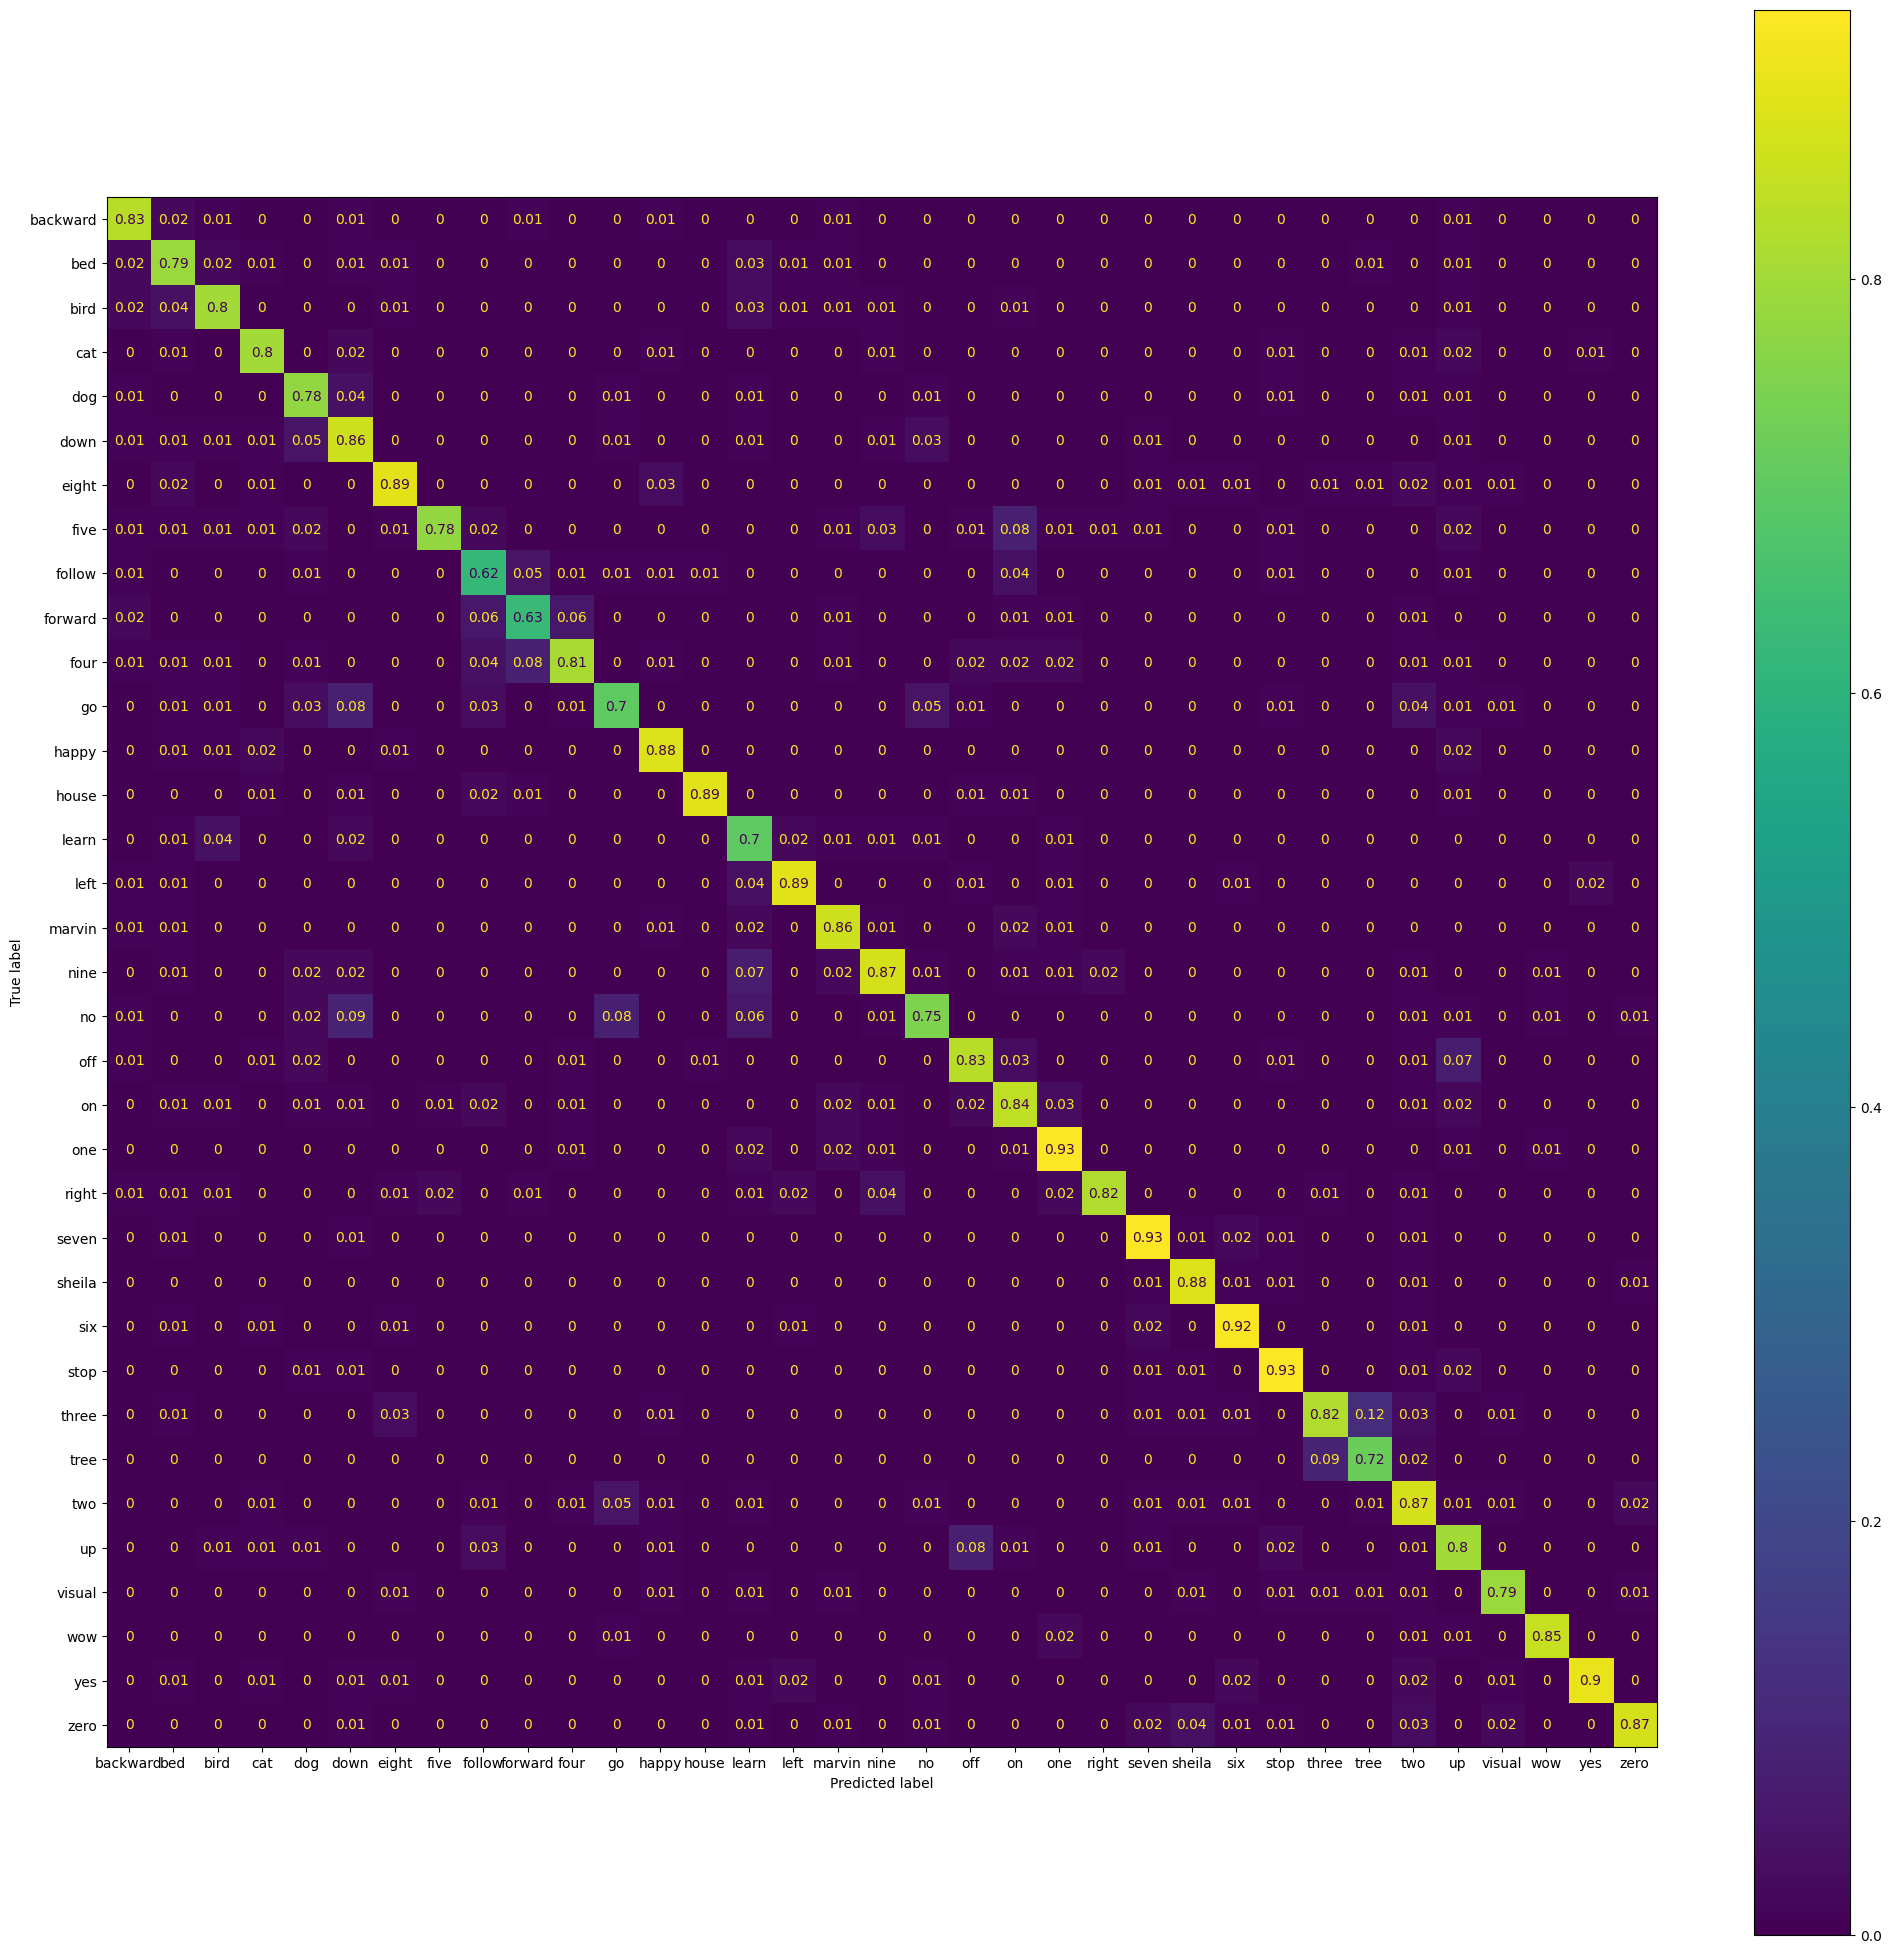

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.831105,0.816260,0.832028,0.831105,0.818781,0.837052,0.831105,0.825997,0.831105,0.831105,0.816260,resnet8_m
1,0.886805,0.881302,0.887548,0.886805,0.879175,0.891072,0.886805,0.880042,0.886805,0.886805,0.881302,CNN_v2_m
2,0.836916,0.824335,0.837109,0.836916,0.828773,0.841104,0.836916,0.836953,0.836916,0.836916,0.824335,CNN_v3_m


**Train Models with MFCC features augmented with noise**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='mfcc', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc', input_noise=True)
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='mfcc', testing=True, input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 99, 8)            136       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 39, 99, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 19, 33, 8)            0         ['activation[0][0]']          
 Pooling2D)                                                                                   

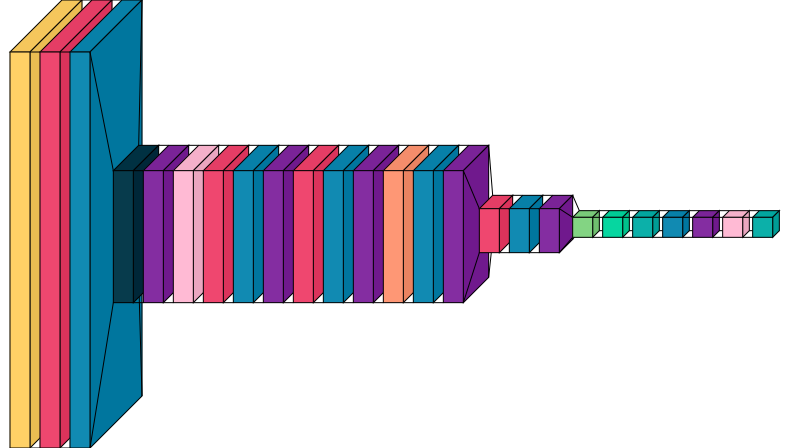

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 515s 338ms/step - loss: 2.5265 - sparse_categorical_accuracy: 0.2816 - val_loss: 2.1867 - val_sparse_categorical_accuracy: 0.3811
Epoch 2/25
497/497 [==============================] - 65s 131ms/step - loss: 1.7834 - sparse_categorical_accuracy: 0.4694 - val_loss: 1.8820 - val_sparse_categorical_accuracy: 0.4648
Epoch 3/25
497/497 [==============================] - 64s 128ms/step - loss: 1.5538 - sparse_categorical_accuracy: 0.5342 - val_loss: 1.5303 - val_sparse_categorical_accuracy: 0.5461
Epoch 4/25
497/497 [==============================] - 63s 127ms/step - loss: 1.4296 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.5412 - val_sparse_categorical_accuracy: 0.5570
Epoch 5/25
497/497 [==============================] - 64s 129ms/step - loss: 1.3552 - sparse_categorical_accuracy: 0.5923 - val_loss: 1.4556 - val_sparse_categorical_accuracy: 0.5775
Epoch 6/25
497/497 [==============================] - 64s 128ms/step - loss: 1.3099 

In [ ]:
CNN_v3_m.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('CNN_v3_mfcc'))
#CNN_v3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('CNN_v3_mfcc'))

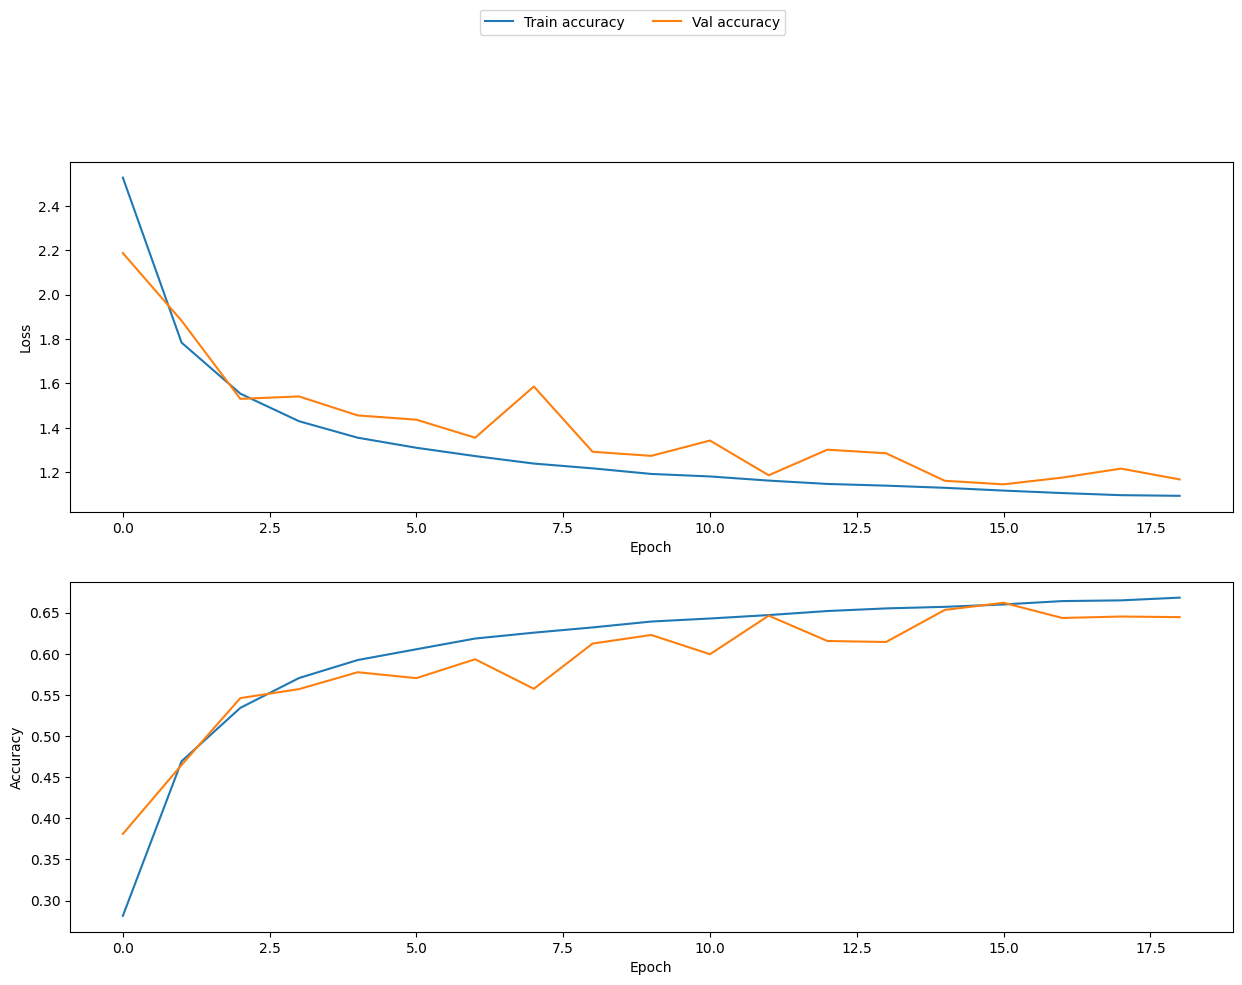

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_CNN_v3.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 148s 894ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.658336,0.642941,0.656231,0.658336,0.645266,0.690896,0.658336,0.689991,0.658336,0.658336,0.642941,CNN_v3


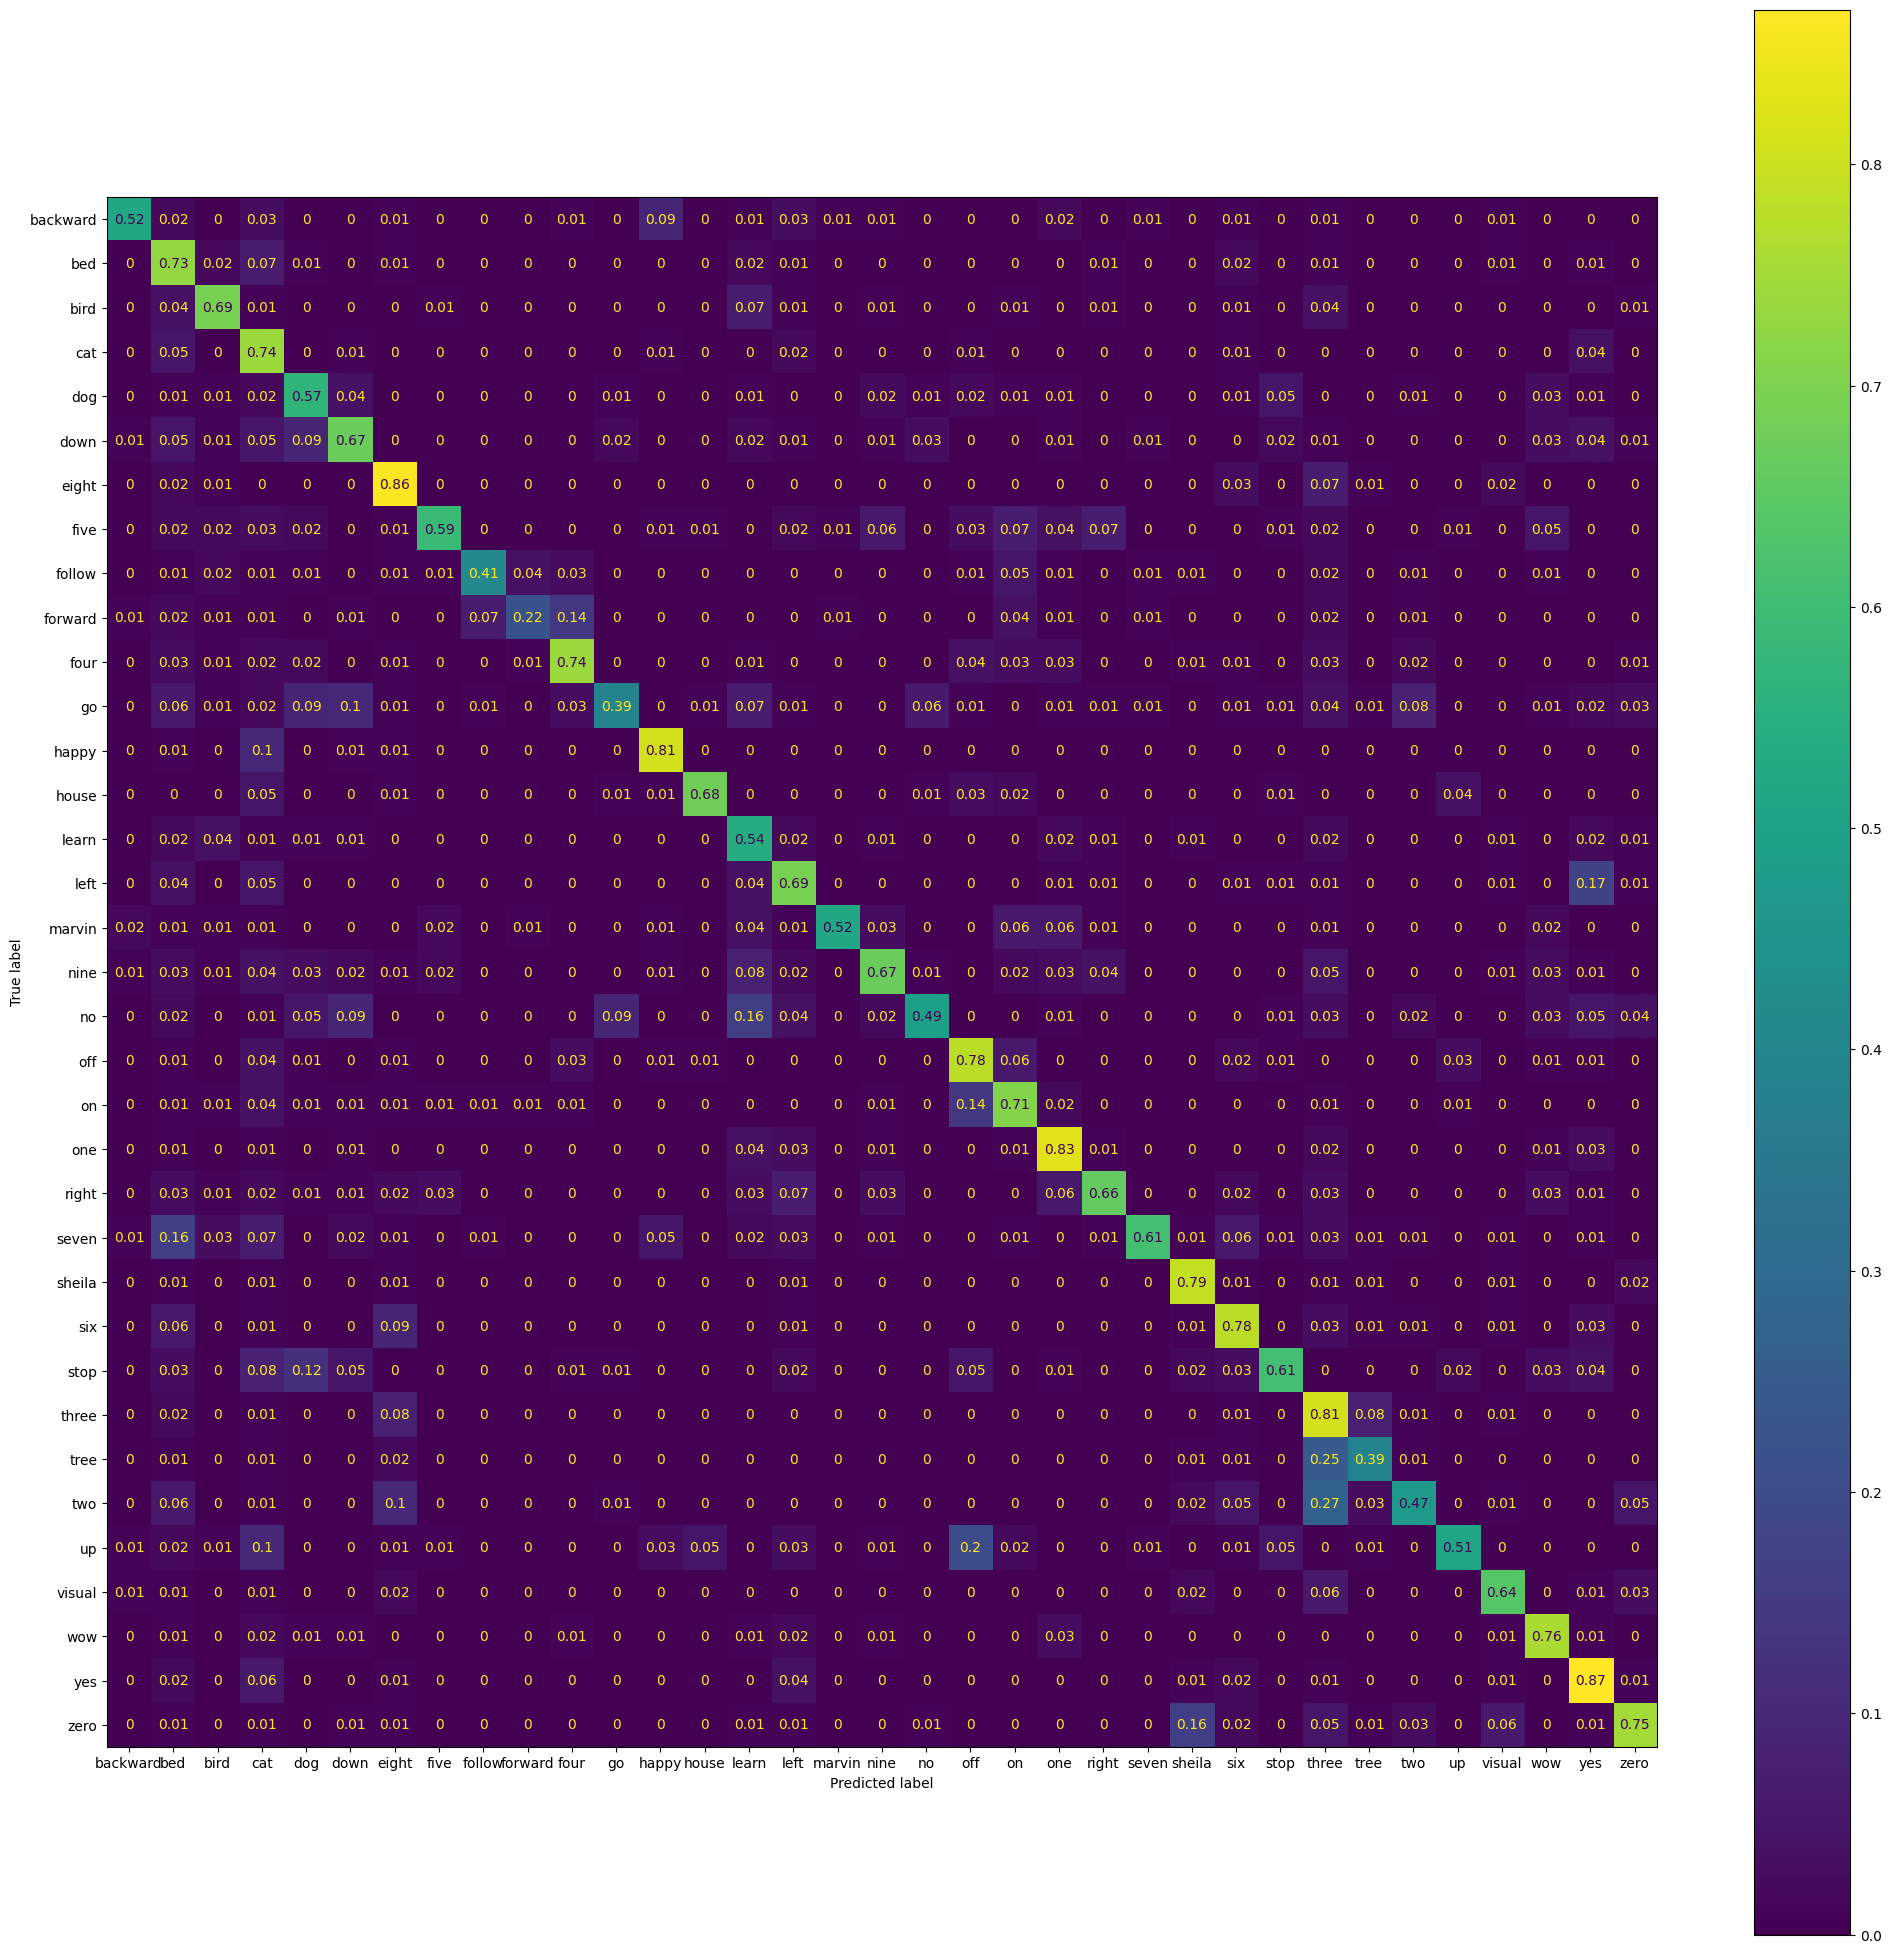

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 20, 50, 8)            328       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 20, 50, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 20, 50, 8)            32        ['activation[0][0]']          
 Normalization)                                                                               

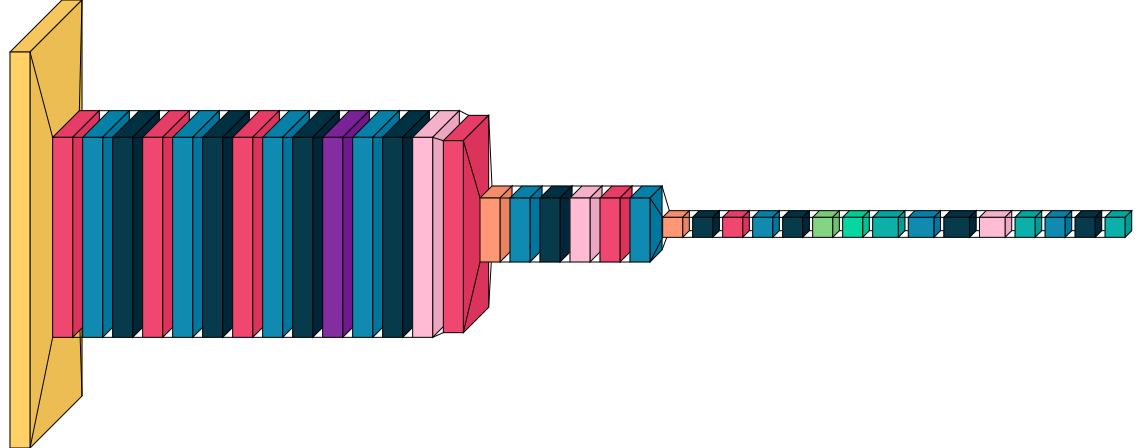

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

CNN_v2 = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2.summary())
visualkeras.layered_view(CNN_v2)

In [ ]:
CNN_v2.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 98s 191ms/step - loss: 2.4188 - sparse_categorical_accuracy: 0.3054 - val_loss: 1.9681 - val_sparse_categorical_accuracy: 0.4135
Epoch 2/25
497/497 [==============================] - 91s 182ms/step - loss: 1.5244 - sparse_categorical_accuracy: 0.5387 - val_loss: 1.3098 - val_sparse_categorical_accuracy: 0.5964
Epoch 3/25
497/497 [==============================] - 94s 188ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.6199 - val_loss: 1.1478 - val_sparse_categorical_accuracy: 0.6516
Epoch 4/25
497/497 [==============================] - 94s 190ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.6567 - val_loss: 1.0111 - val_sparse_categorical_accuracy: 0.6902
Epoch 5/25
497/497 [==============================] - 89s 179ms/step - loss: 1.0479 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.9627 - val_sparse_categorical_accuracy: 0.7069
Epoch 6/25
497/497 [==============================] - 94s 189ms/step - loss: 0.9896 -

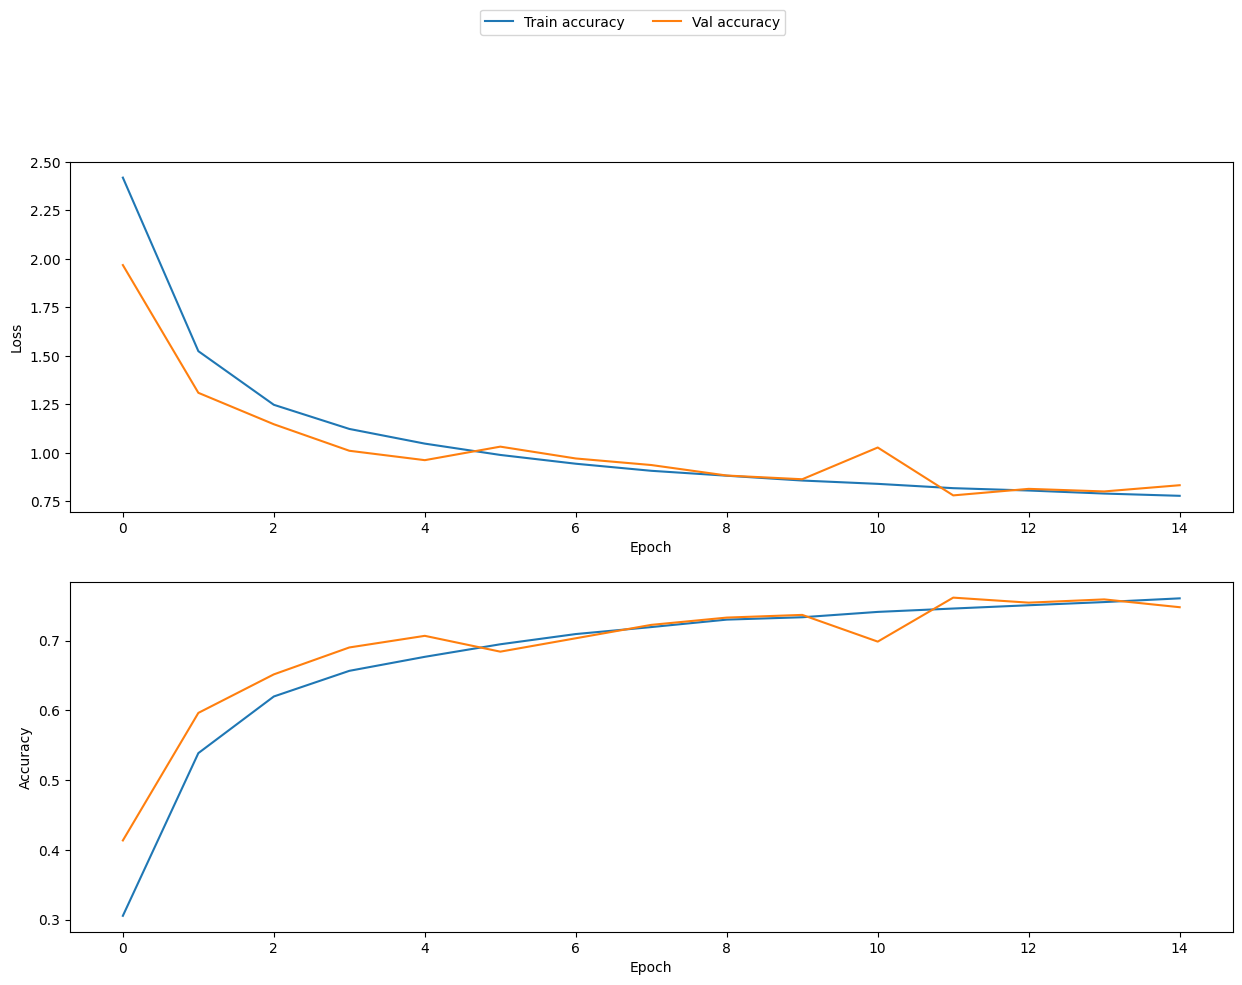

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
CNN_v2.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('CNN_v2_mfcc'))
#CNN_v2=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('CNN_v2_mfcc'))

In [ ]:

pred=CNN_v2.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 5s 33ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.658336,0.642941,0.656231,0.658336,0.645266,0.690896,0.658336,0.689991,0.658336,0.658336,0.642941,CNN_v3
1,0.757405,0.750576,0.757102,0.757405,0.750926,0.767363,0.757405,0.763813,0.757405,0.757405,0.750576,CNN_v2


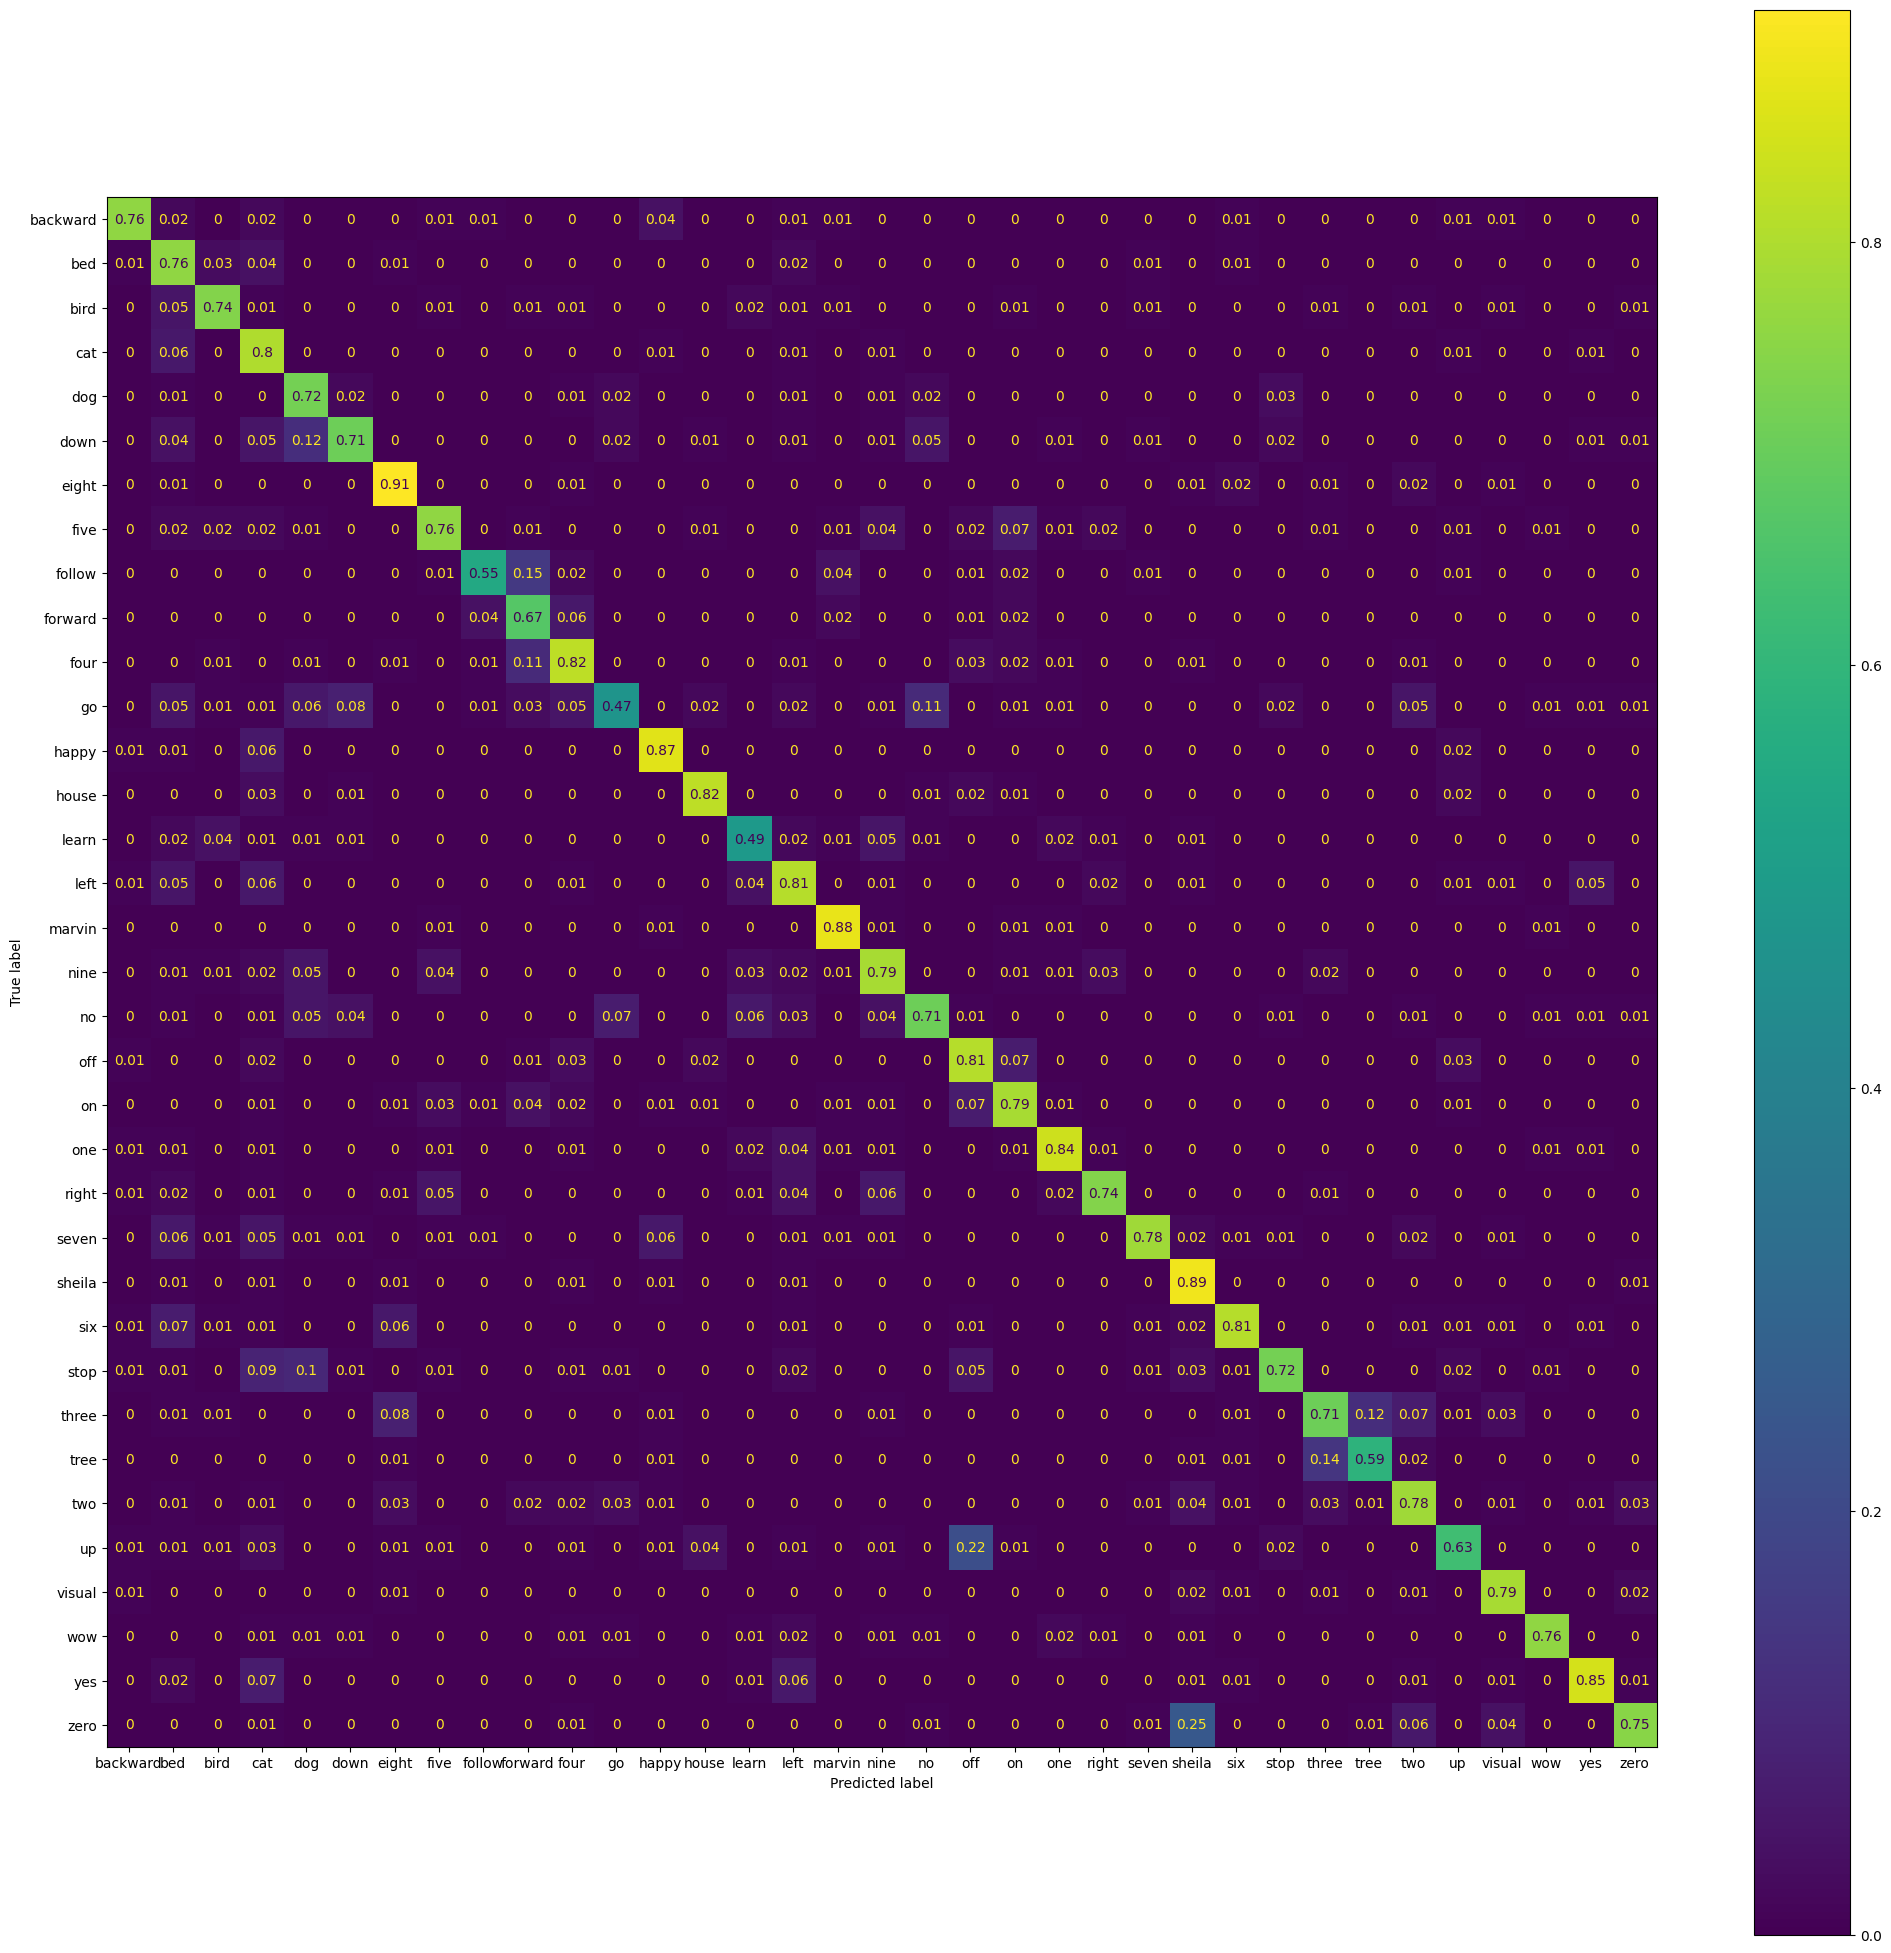

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 9, 33, 19)            0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 9, 33, 19)            3268      ['average_pooling2d[0][0]'

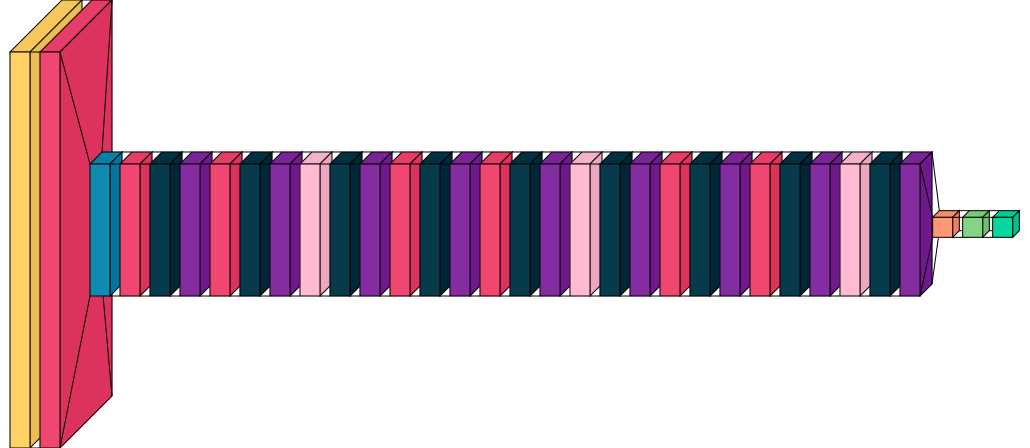

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

resnet8_m = resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [ ]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 81s 160ms/step - loss: 2.6817 - sparse_categorical_accuracy: 0.2892 - val_loss: 2.2623 - val_sparse_categorical_accuracy: 0.3466
Epoch 2/25
497/497 [==============================] - 75s 151ms/step - loss: 1.7798 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.7533 - val_sparse_categorical_accuracy: 0.4895
Epoch 3/25
497/497 [==============================] - 79s 159ms/step - loss: 1.4287 - sparse_categorical_accuracy: 0.5947 - val_loss: 1.3967 - val_sparse_categorical_accuracy: 0.5867
Epoch 4/25
497/497 [==============================] - 81s 162ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.6472 - val_loss: 1.6720 - val_sparse_categorical_accuracy: 0.5113
Epoch 5/25
497/497 [==============================] - 76s 153ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.6791 - val_loss: 1.3298 - val_sparse_categorical_accuracy: 0.6167
Epoch 6/25
497/497 [==============================] - 76s 152ms/step - loss: 1.0297 -

In [ ]:
resnet8_m.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('resnet8_mfcc'))
#resnet8_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('resnet8_mfcc'))

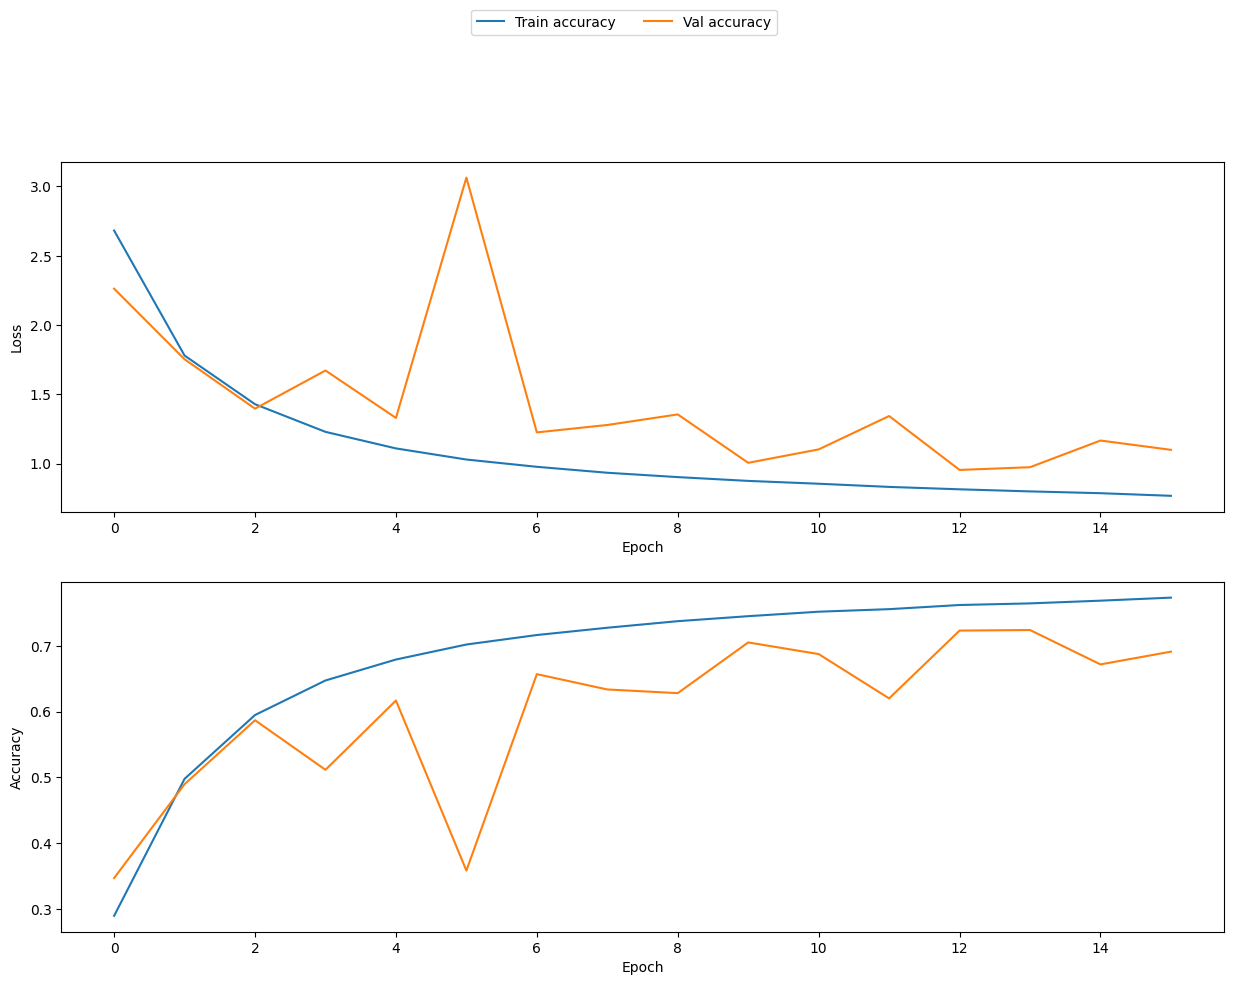

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_resnet8.history['loss'], label='Train loss')
axis[0].plot(history_resnet8.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 5s 29ms/step


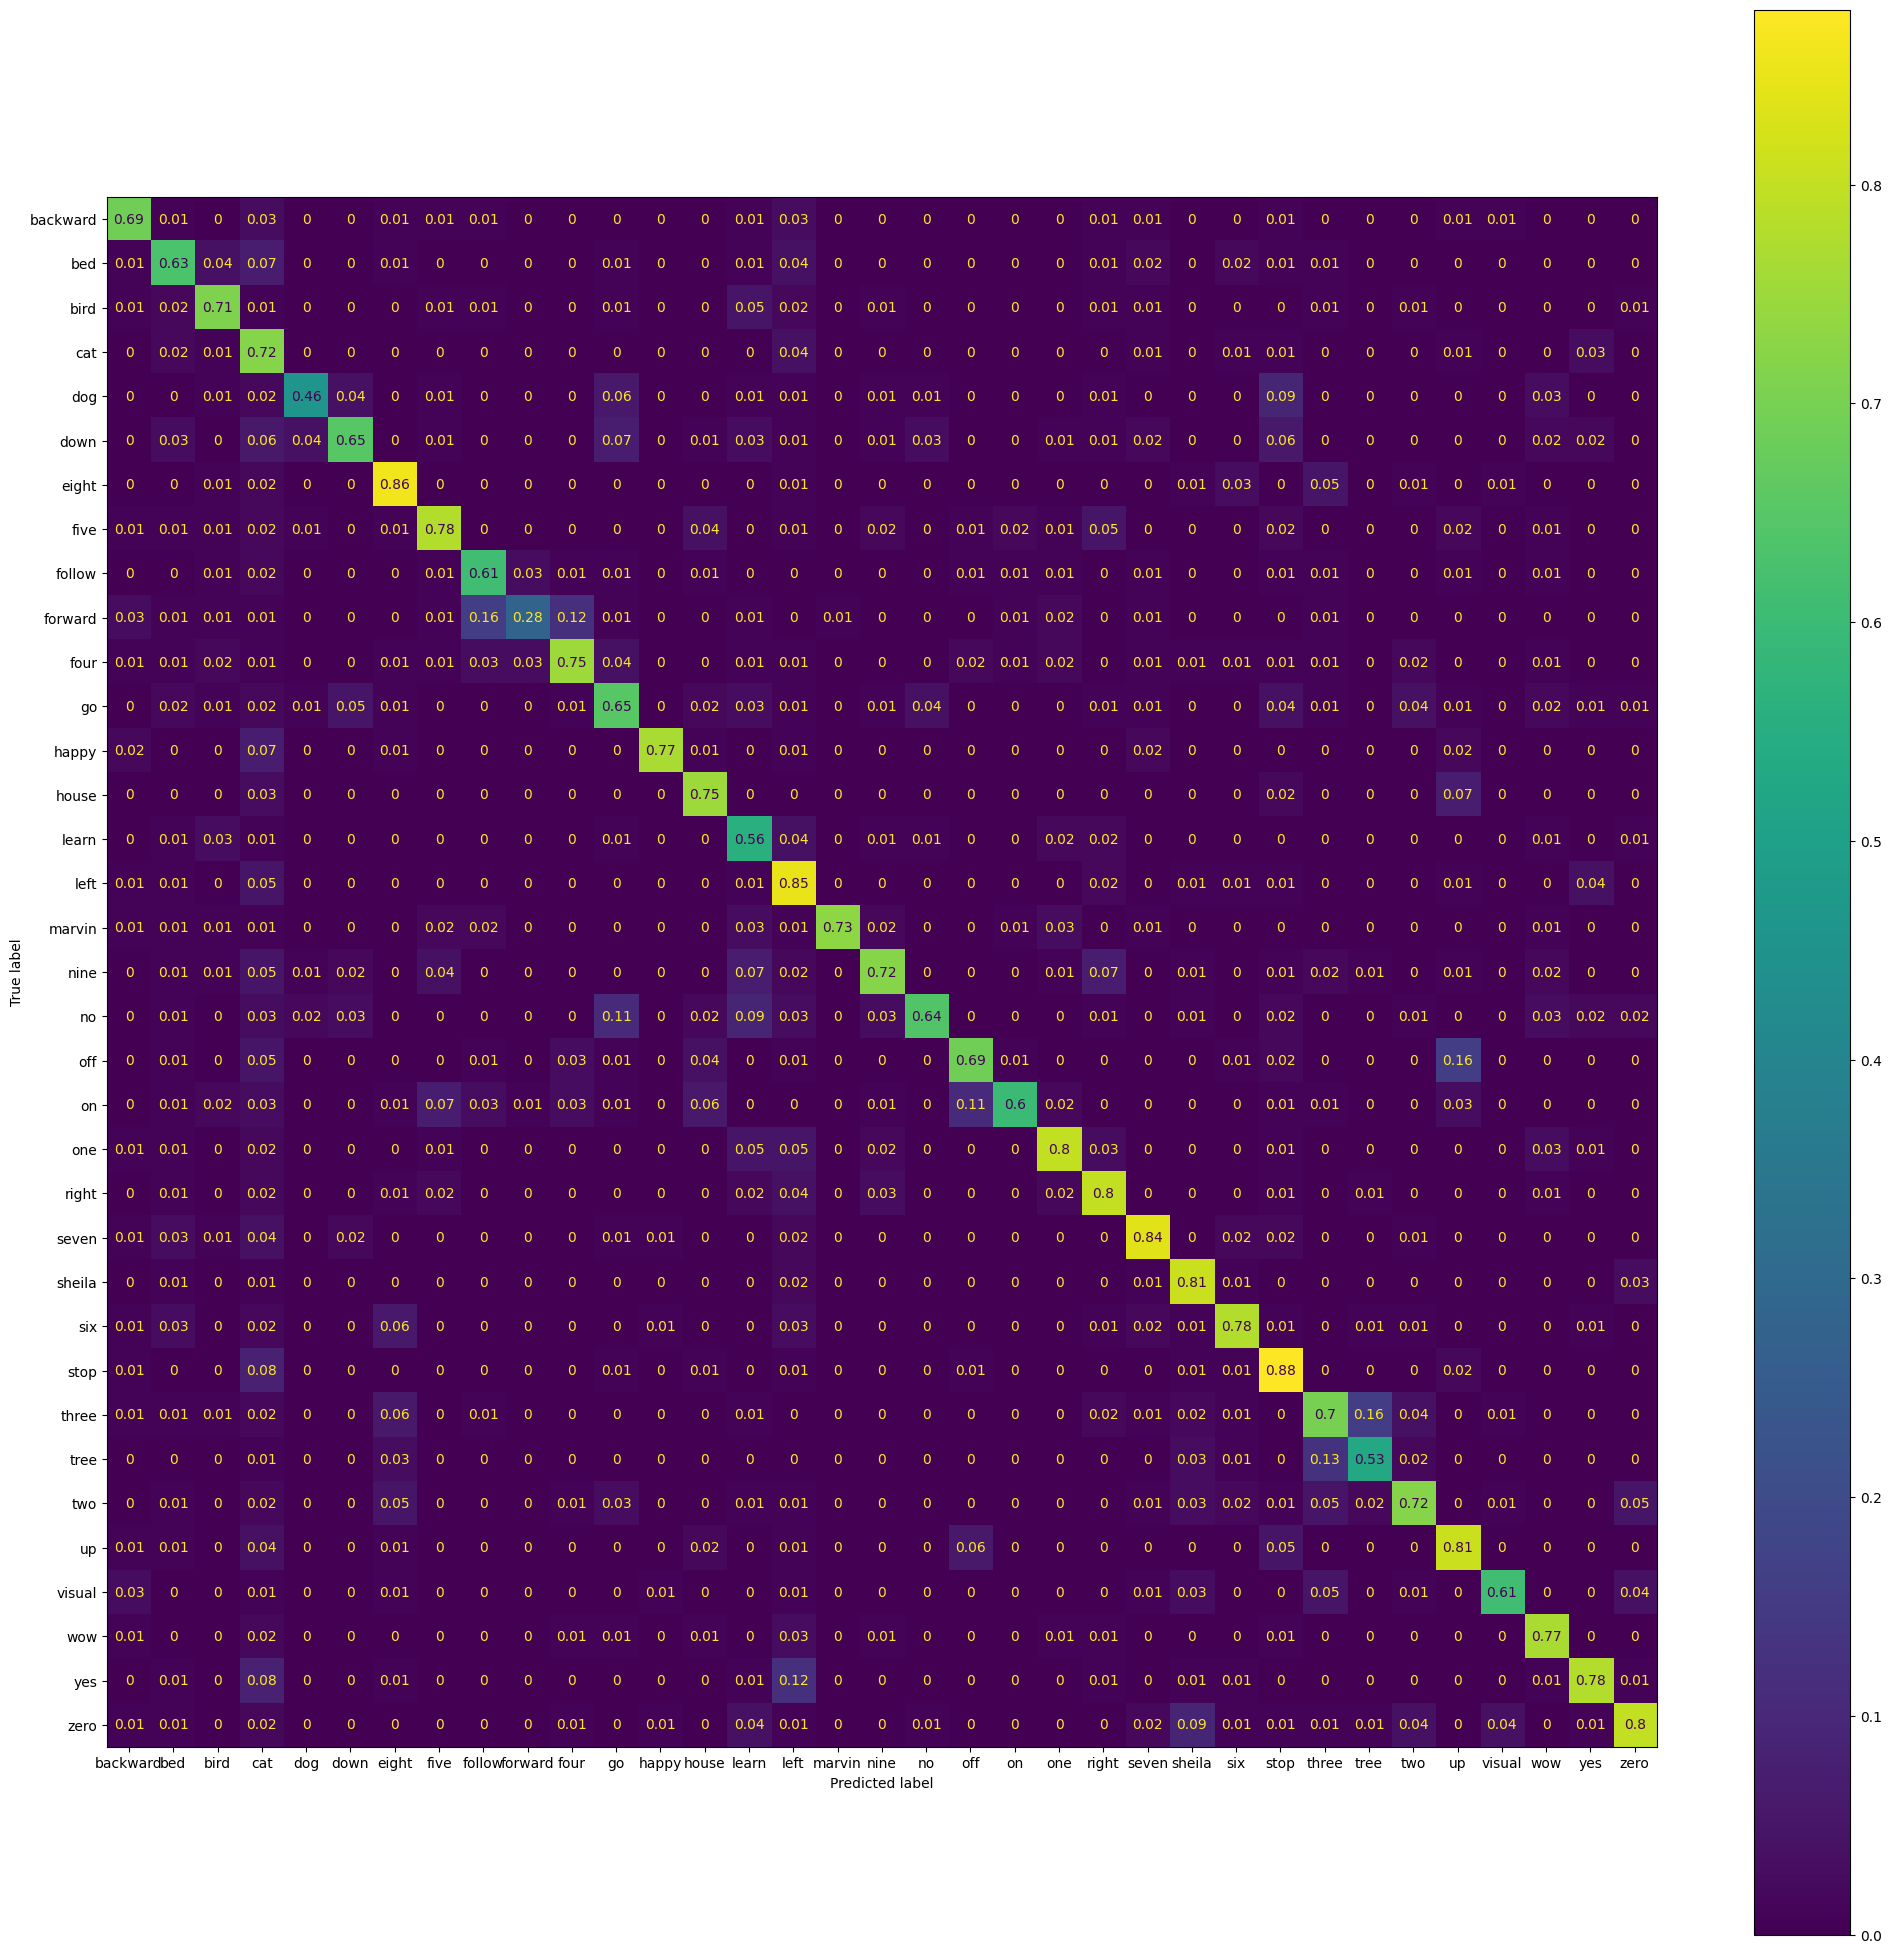

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.658336,0.642941,0.656231,0.658336,0.645266,0.690896,0.658336,0.689991,0.658336,0.658336,0.642941,CNN_v3
1,0.757405,0.750576,0.757102,0.757405,0.750926,0.767363,0.757405,0.763813,0.757405,0.757405,0.750576,CNN_v2
2,0.726603,0.706196,0.726098,0.726603,0.712290,0.743217,0.726603,0.740252,0.726603,0.726603,0.706196,resnet8_m
